Visualizacion datos año 2016

In [105]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SequentialFeatureSelector as SFFS
from sklearn.exceptions import ConvergenceWarning
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import PolynomialFeatures

# Importaciones para la predicción (extra)
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor


# Importaciones para la búsqueda de hiperparámetros
from sklearn.model_selection import GridSearchCV

# Importaciones para la medida de calidad de la predicción

from sklearn.model_selection import cross_val_score
import multiprocessing
from sklearn.metrics import r2_score

In [106]:
# Cargar el archivo CSV en un DataFrame
df = pd.read_csv('nacimientos_2016_2021.csv')
df

PROI  SEXO  MESPAR  ANOPAR  count
0        1     1       1    2021     98
1        1     1       2    2021     92
2        1     1       3    2021    108
3        1     1       4    2021     99
4        1     1       5    2021     90
...    ...   ...     ...     ...    ...
7483    52     6       8    2016     87
7484    52     6       9    2016     84
7485    52     6      10    2016     96
7486    52     6      11    2016     82
7487    52     6      12    2016     84

[7488 rows x 5 columns]

Entendemos que no habrá valores repetidos ya que cada fila es una provincia, un sexo y una fecha por lo cual no hay filas repetidas.

Para ver si sabemos manejar los datos, probamos a ver los nacimientos por mes de cada sexo en todo el país en el año 2016.

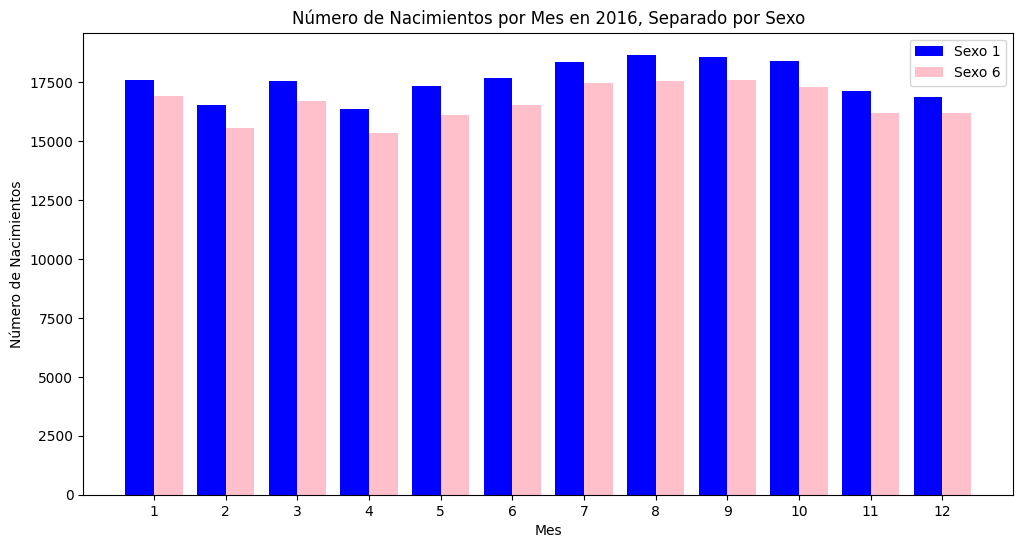

In [ ]:
# Filtramos datos solo para el año 2016
df_2016 = df[df['ANOPAR'] == 2016]


#Así se tiene en cada columa de mes el número de nacimientos totales de cada género.
grouped_data = df_2016.groupby(['MESPAR', 'SEXO'])['count'].sum().reset_index()

# Creamos la visualización
fig, ax = plt.subplots(figsize=(12, 6))

# Configuramos colores para los dos sexos
colors = ['blue', 'pink']

# Posiciones de las barras para cada mes
x_positions = np.arange(1, 13)

# Ancho de cada barra
bar_width = 0.4

# Iteramos sobre cada género
for i, (sex, group_sex) in enumerate(grouped_data.groupby('SEXO')):
    # Dibujamos barras apiladas para cada mes
    ax.bar(
        x_positions + i * bar_width,
        group_sex['count'],
        bar_width,
        label=f'Sexo {sex}',
        color=colors[i],
        align='center'
    )

# Etiquetas en el eje x
ax.set_xticks(x_positions + bar_width / 2)
ax.set_xticklabels(range(1, 13))

# Configuramos leyenda y etiquetas
ax.legend()
ax.set_xlabel('Mes')
ax.set_ylabel('Número de Nacimientos')
ax.set_title('Número de Nacimientos por Mes en 2016, Separado por Sexo')


plt.show()


Vemos que al menos en este caso, el mes no parece afectar al número de nacimientos.

Creación de un dataset por cada sexo

In [ ]:
# Crear dos nuevos conjuntos de datos, uno para cada sexo
varon = df[df['SEXO'] == 1].drop('SEXO', axis=1)
mujer = df[df['SEXO'] == 6].drop('SEXO', axis=1)



# Mostrar los nuevos conjuntos de datos
print("Conjunto de datos para Sexo 1:")
print(varon)

print("\nConjunto de datos para Sexo 6:")
print(mujer)


Conjunto de datos para Sexo 1:
      PROI  MESPAR  ANOPAR  count
0        1       1    2021     98
1        1       2    2021     92
2        1       3    2021    108
3        1       4    2021     99
4        1       5    2021     90
...    ...     ...     ...    ...
7471    52       8    2016    103
7472    52       9    2016     94
7473    52      10    2016     90
7474    52      11    2016     97
7475    52      12    2016     91

[3744 rows x 4 columns]

Conjunto de datos para Sexo 6:
      PROI  MESPAR  ANOPAR  count
12       1       1    2021     76
13       1       2    2021     90
14       1       3    2021     87
15       1       4    2021     99
16       1       5    2021     85
...    ...     ...     ...    ...
7483    52       8    2016     87
7484    52       9    2016     84
7485    52      10    2016     96
7486    52      11    2016     82
7487    52      12    2016     84

[3744 rows x 4 columns]


Creamos una funcion que haga un dataset de una provincia en específico

In [ ]:
def crear_provincia(proi,df):
    data = df[df['PROI'] == proi].drop('PROI',axis=1)
    return data

provincia1 = crear_provincia(1,varon)
provincia1.reset_index(drop=True, inplace=True)
provincia1

MESPAR  ANOPAR  count
0        1    2021     98
1        2    2021     92
2        3    2021    108
3        4    2021     99
4        5    2021     90
..     ...     ...    ...
67       8    2016    139
68       9    2016    126
69      10    2016    134
70      11    2016    121
71      12    2016    119

[72 rows x 3 columns]

Vamos a ver como evolucionan los nacimientos en la provincia 1 a lo largo de los años.

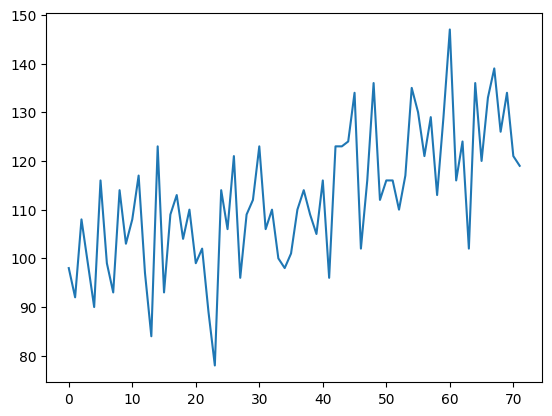

In [ ]:
X = provincia1["count"]

plt.plot(X)

Se puede ver que avanza al alza a medida que se retrocede en el tiempo, ya que los datos comienzan en 2021, por lo que se podria decir que hace años habia mas nacimientos, al menos en esta provincia.

Unimos año y mes para crear fecha y asi poder trabajar mejor con ella, esto lo hacemos en la funcion transformar_dataframe2:

In [ ]:
def transformar_dataframe2(df):
    # Creamos la columna 'fecha' combinando 'año' y 'mes'
    df['fecha'] = pd.to_datetime(df['ANOPAR'].astype(str) + df['MESPAR'].astype(str).str.zfill(2), format='%Y%m')

    # Convertimos 'fecha' a tipo object (cadena de caracteres)
    df['fecha'] = df['fecha'].astype('str')

    # Seleccionamos las columnas relevantes
    nuevo_df = df[['fecha', 'count']]

    return nuevo_df

<Axes: xlabel='fecha'>

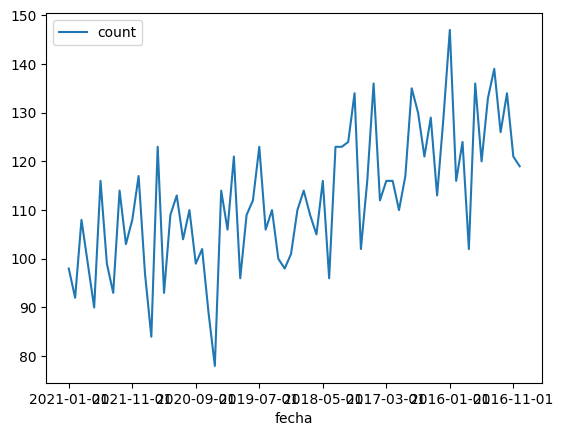

In [ ]:
prov1_trans = transformar_dataframe2(provincia1)
prov1_trans.plot(x='fecha', y = 'count')

Es el mismo ejemplo de antes pero se puede ver que en el eje x estan los años, asi se entiende mejor la tendencia de los ultimos años.

Vamos a ver ahora como evoluciona cada mes a lo largo de los años para ver si hay una tendencia general sobre el numero de nacimientos en un determinado mes. Ademas de ver si se cumple el decrecimiento de nacimientos a medida que pasa el tiempo.

In [ ]:
#Recogemos los meses que tiene un año
months = []
for m in range(12):
    months.append(prov1_trans.iloc[m::12])

Cada color es como ha evolucionado un mes con el paso de los años, va al alza porque el dataset empieza en 2021 y acaba en 2016, lo que significa que en el pasado habían más nacimientos en cada mes.

In [ ]:
nombre_meses = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']

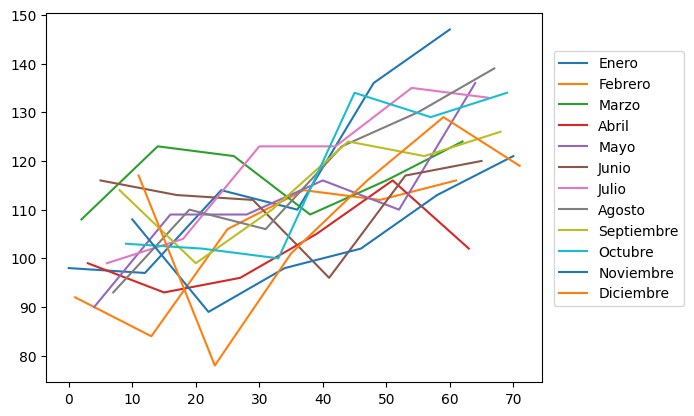

In [ ]:
for m in range(12):
    plt.plot(months[m]['count'], label=nombre_meses[m])

plt.legend(loc='right', bbox_to_anchor=(0.3, 0.5, 1., .102))  # Mostrar la leyenda
plt.show()

Cada color es un año y sus valores en cada mes, creemos que es mejor que el anterior ya que así se ve de forma más clara la diferencia en el paso del tiempo.


De esta forma, entregando una provincia en específico se puede visualizar su progreso con el paso de los años, de forma separada para hombres o para mujeres:

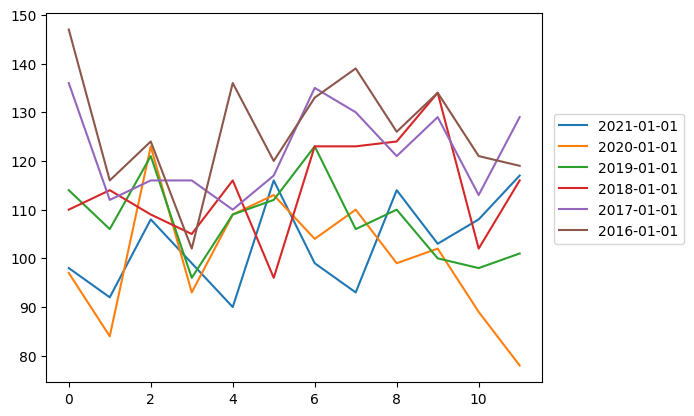

In [ ]:
def años_por_provincia(proi, df):
    # Creamos un DataFrame para la provincia específica
    a = crear_provincia(proi, df)

    # Unificamos la fecha utilizando transformar_dataframe2
    a = transformar_dataframe2(a)

    # Iteramos sobre el DataFrame por bloques de 12 meses
    for i in range(0, a.shape[0], 12):
        if a.shape[0] - i >= 12:
            # Graficamos los datos para cada bloque de 12 meses
            plt.plot(range(12), a.iloc[i:i+12]['count'])

    # Creamos una leyenda usando las fechas de inicio de cada bloque de 12 meses
    plt.gca().legend(a.iloc[::12]['fecha'], loc='right', bbox_to_anchor=(0.3, 0.5, 1., .102))

# Ejemplo de uso con la provincia 1 y el DataFrame 'varon'
años_por_provincia(1, varon)


#En este ejemplo vemos en la provincia 1 el progreso de nacimiento de varones con el paso de los años.

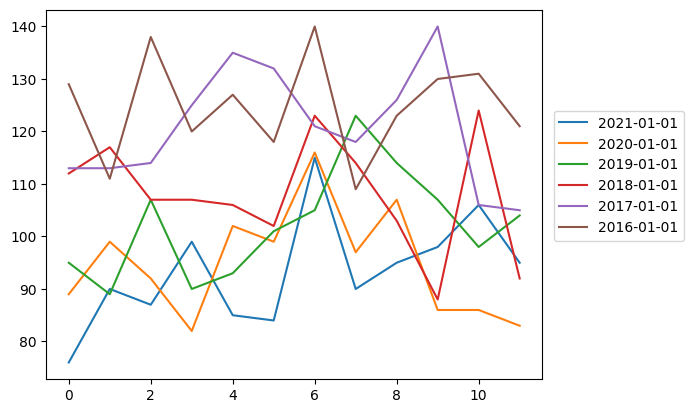

In [ ]:
años_por_provincia(1,mujer)
#En este ejemplo vemos en la provincia 1 el progreso de nacimiento de varones con el paso de los años.

Si quisieramos ver el progreso de una provincia en total, sin distinguir entre hombres y mujeres, preparamos un nuevo dataset que sume los valores de varones y mujeres por provincia.

In [ ]:
suma_provincia = varon.drop('count',axis=1)

#Reseteamos los index para asi poder unirlos
varon.reset_index(drop=True, inplace=True)
mujer.reset_index(drop=True, inplace=True)

suma_provincia['count'] = varon['count'] + mujer['count']
suma_provincia

PROI  MESPAR  ANOPAR  count
0        1       1    2021  174.0
1        1       2    2021  182.0
2        1       3    2021  195.0
3        1       4    2021  198.0
4        1       5    2021  175.0
...    ...     ...     ...    ...
7471    52       8    2016    NaN
7472    52       9    2016    NaN
7473    52      10    2016    NaN
7474    52      11    2016    NaN
7475    52      12    2016    NaN

[3744 rows x 4 columns]

Ya tenemos un dataset con el valor de varon más el de mujer en count y podemos aplicar lo mismo que antes.

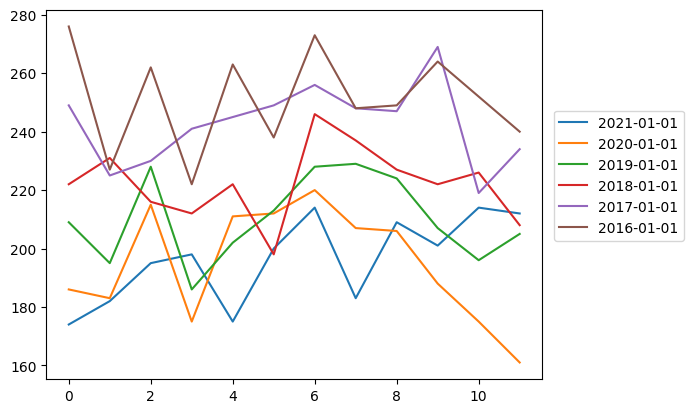

In [ ]:
años_por_provincia(1,suma_provincia)

Ahora lo viualizaremos de forma que podamos ver la evolución del país en general. Sumando por cada mes de cada año el total de todas las provicias del país. Distinguiendo entre nacimientos de hombres y mujeres (despúes también lo veremos de forma total sin importar el sexo)

creamos pais_fechas que une mes y año

In [ ]:
def transformar_a_pais(df):
    # Creamos la columna 'fecha' combinando 'año' y 'mes'
    df['fecha'] = pd.to_datetime(df['ANOPAR'].astype(str) + df['MESPAR'].astype(str).str.zfill(2), format='%Y%m')

    # Convertimos 'fecha' a tipo object (cadena de caracteres)
    df['fecha'] = df['fecha'].astype('str')

    # Seleccionamos las columnas relevantes
    nuevo_df = df[['PROI','fecha', 'count']]
    nuevo_df = nuevo_df.groupby('fecha')['count'].sum().reset_index()
    return nuevo_df

Creamos total_varones y total_mujeres que será el nacimiento de varones/mujeres en el país entero durante cada mes de cada año

In [ ]:
total_varones = transformar_a_pais(varon)
total_varones

fecha  count
0   2016-01-01  17589
1   2016-02-01  16526
2   2016-03-01  17573
3   2016-04-01  16387
4   2016-05-01  17341
..         ...    ...
67  2021-08-01  15324
68  2021-09-01  15550
69  2021-10-01  15666
70  2021-11-01  14596
71  2021-12-01  14603

[72 rows x 2 columns]

In [ ]:
total_mujeres = transformar_a_pais(mujer)
total_mujeres

fecha  count
0   2016-01-01  16901
1   2016-02-01  15567
2   2016-03-01  16719
3   2016-04-01  15332
4   2016-05-01  16098
..         ...    ...
67  2021-08-01  14316
68  2021-09-01  14679
69  2021-10-01  14469
70  2021-11-01  13856
71  2021-12-01  13971

[72 rows x 2 columns]

Creamos función que visualice los datos

In [ ]:
def años_por_pais(df):
    # Iteramos sobre el DataFrame por bloques de 12 meses
    for i in range(0, df.shape[0], 12):
        if df.shape[0] - i >= 12:
            # Graficamos los datos para cada bloque de 12 meses
            plt.plot(range(12), df.iloc[i:i+12]['count'])

    # Creamos una leyenda usando las fechas de inicio de cada bloque de 12 meses
    plt.gca().legend(df.iloc[::12]['fecha'], loc='right', bbox_to_anchor=(0.3, 0.5, 1., .102))


Vemos los nacimientos en todo el país para los varones. Observamos como claramente ha ido disminuyendo el número de nacimiento.

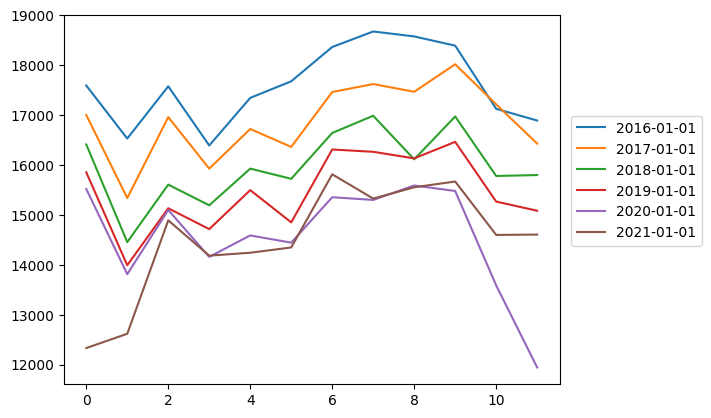

In [ ]:
años_por_pais(total_varones)

Vemos los nacimientos en todo el país para las mueres. Observamos como claramente ha ido disminuyendo el numero de nacimientos.

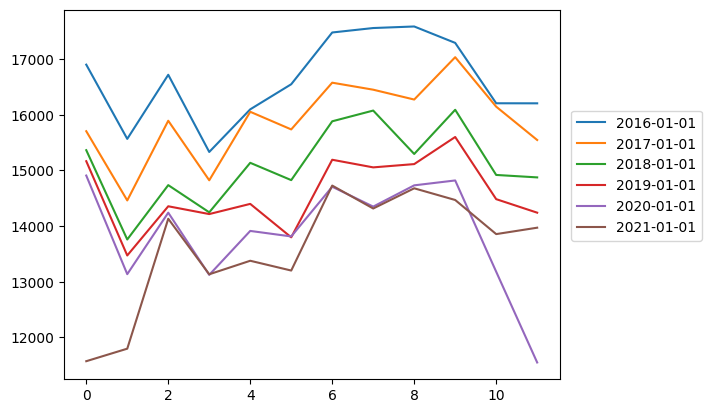

In [ ]:
años_por_pais(total_mujeres)

Por último vemos el total de nacimientos en todo el país tanto para hombres como para mujeres. Para ello creamos un dataset que sume los valores count de total_varones y total_mujeres en su misma fecha.

In [ ]:
suma_pais = total_varones.drop('count',axis=1)
suma_pais['count'] = total_varones['count'] + total_mujeres['count']
suma_pais

fecha  count
0   2016-01-01  34490
1   2016-02-01  32093
2   2016-03-01  34292
3   2016-04-01  31719
4   2016-05-01  33439
..         ...    ...
67  2021-08-01  29640
68  2021-09-01  30229
69  2021-10-01  30135
70  2021-11-01  28452
71  2021-12-01  28574

[72 rows x 2 columns]

Ahora vemos la visión más general posible, en todo el país, tanto en hombres como en mujeres, el total de nacimientos va disminuyendo con el paso de los años.

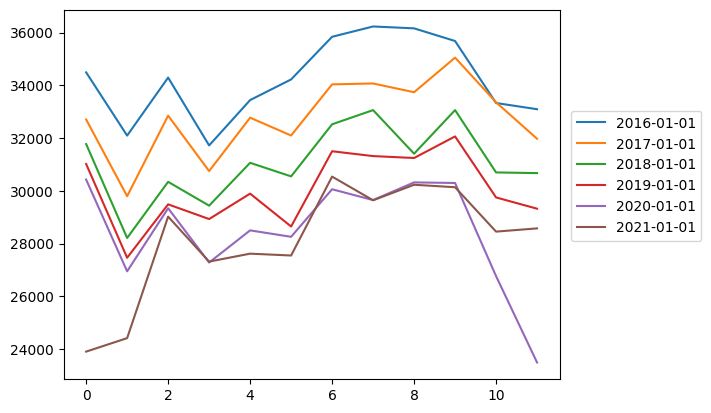

In [ ]:
años_por_pais(suma_pais)

Probamos predecir con métodos clásicos de regresión pero suponemos que los resultados no serán buenos.

reg lineal

In [ ]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [ ]:
# Cargar el archivo CSV en un DataFrame
df = pd.read_csv('nacimientos_2016_2021.csv')

# Filtrar datos solo para el año 2021
df_2021 = df[df['ANOPAR'] == 2021]

# Filtrar y seleccionar los datos anteriores al año 2021
previous_data = df[df['ANOPAR'] < 2021][['MESPAR', 'SEXO', 'PROI', 'count']]

# Crear conjuntos de entrenamiento y prueba
'''X_train, X_test, y_train, y_test = train_test_split(
    previous_data.drop('count', axis=1),
    previous_data['count'],
    test_size=0.2,
    random_state=42
)'''

X_train = previous_data.drop('count', axis=1)
y_train = previous_data['count']

# Entrenar un modelo (puedes elegir el modelo que mejor se adapte a tus datos)
model = LinearRegression()
model.fit(X_train, y_train)

# Realizar predicciones para el año 2021
predictions_2021 = model.predict(df_2021[['MESPAR', 'SEXO', 'PROI']])

# Calcular la métrica MAE
mae_2021 = mean_absolute_error(df_2021['count'], predictions_2021)

# Mostrar el resultado
print(f'MAE para el año 2021: {mae_2021}')


MAE para el año 2021: 227.9104833094711


Efectivamente vemos que no nos servirá.

Dataset 2022

In [ ]:
#Cogemos los datos del dataframe de 2016 y quitamos 'count'
#porque se añadira mas tarde con los valores predichos para 2022
df_2022 = df[df['ANOPAR'] == 2016]
df_2022['ANOPAR'] = 2022
df_2022 = df_2022.drop('count', axis=1)
print(df_2022)

      PROI  SEXO  MESPAR  ANOPAR
6240     1     1       1    2022
6241     1     1       2    2022
6242     1     1       3    2022
6243     1     1       4    2022
6244     1     1       5    2022
...    ...   ...     ...     ...
7483    52     6       8    2022
7484    52     6       9    2022
7485    52     6      10    2022
7486    52     6      11    2022
7487    52     6      12    2022

[1248 rows x 4 columns]


<ipython-input-99-c8b34e7d33de>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2022['ANOPAR'] = 2022


Vamos a graficar los datos hasta 2021 en azul, y los de 2021 en rojo.

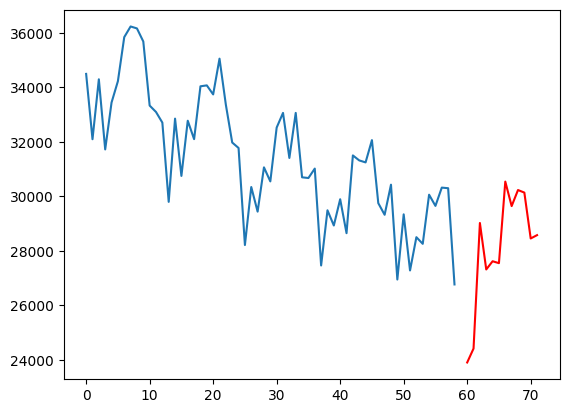

In [ ]:
X = suma_pais["count"]
X_train = X[:59]
X_test = X[60:suma_pais.shape[0]]

T_missing = range(60, 72)

plt.plot(X_train)
plt.plot(X_test, color='red')
plt.show()

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

Vamos a analizar los datos para entender si nuestros datos son estacionarios o estacionales. Por sentido común y por lo observado en los gráficos hemos pensado que es estacionario ya que no parece haber distinción entre meses, pareciendo que hay la misma ocurrencia de nacimientos media en cada uno.

0             NaN
1             NaN
2             NaN
3             NaN
4             NaN
5             NaN
6    34140.791667
7    33970.583333
8    33814.708333
9    33714.083333
Name: trend, dtype: float64
0     -618.654861
1    -3117.963194
2     -172.429861
3    -1542.213194
4     -228.379861
         ...     
67    1804.186806
68    1620.520139
69    2357.353472
70      -7.421528
71    -972.863194
Name: seasonal, Length: 72, dtype: float64
0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
5           NaN
6    120.054861
7    455.229861
8    723.771528
9   -392.436806
Name: resid, dtype: float64
0     34490.0
1     32093.0
2     34292.0
3     31719.0
4     33439.0
       ...   
67    29640.0
68    30229.0
69    30135.0
70    28452.0
71    28574.0
Name: count, Length: 72, dtype: float64


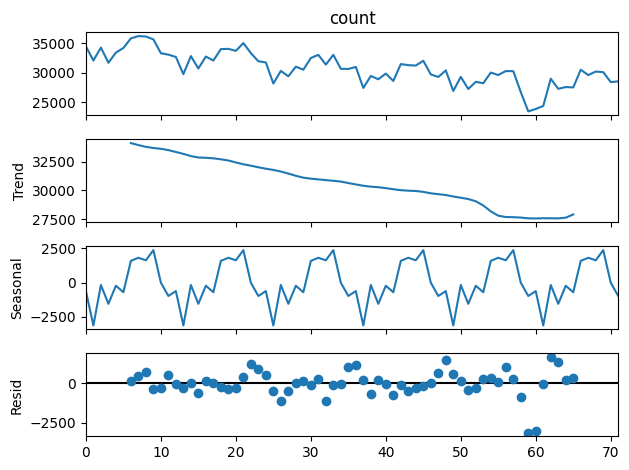

In [ ]:
result = seasonal_decompose(suma_pais['count'], model='additive', period = 12)
result.plot()
print(result.trend[:10])
print(result.seasonal)
print(result.resid[:10])
print(result.observed)

A pesar de lo comentado, vemos en el gráfico de seasonal que parece tener seasonality, por tanto nos ceñiremos a las pruebas y comprobaremos si obtenemos mejor resultado con arima o sarimax.

Tras ver que métodos clásicos no es el camino, probamos con ARMA

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


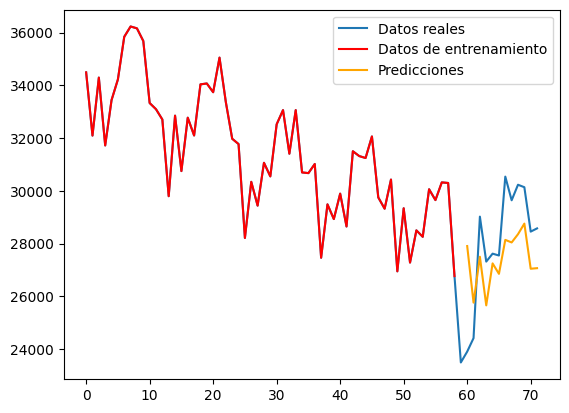

In [ ]:
# ARIMA

# Definimos los periodos de tiempo faltantes
T_missing = range(60, 72)

# Obtenemos los datos como un array NumPy
X = suma_pais["count"].to_numpy()

# Dividimos los datos en entrenamiento y prueba
X_train = suma_pais['count'][:59]
X_test = X[60:72]

# Creamos el modelo ARIMA
model1 = ARIMA(X_train, order=(25, 1, 5))
model_fit1 = model1.fit()

# Realizamos predicciones para los periodos faltantes
X_hat_series = model_fit1.predict(start=T_missing[0], end=T_missing[-1], dynamic=True)

# Graficamos los resultados
plt.plot(X, label='Datos reales')
plt.plot(X_train, color='red', label='Datos de entrenamiento')
plt.plot(T_missing, X_hat_series, color='orange', label='Predicciones')
plt.legend()

# Mostramos la figura
plt.show()


X_hat_series son los resultados

In [ ]:
X_hat_series

60    27904.931358
61    25759.414560
62    27498.999891
63    25655.463284
64    27247.185547
65    26850.618772
66    28138.831524
67    28040.950875
68    28353.467539
69    28755.708757
70    27044.255760
71    27065.911220
Name: predicted_mean, dtype: float64

In [ ]:
arma_mae = mean_absolute_error(X[T_missing], X_hat_series)
print(arma_mae)

1646.9127292730561


In [ ]:
r2 = r2_score(X[T_missing], X_hat_series)
print(r2)

0.17888376671219552


Prueba con SARIMAX, seasonal order a 12 ya que son los meses de un año, que sería un ciclo cadad 12 filas.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


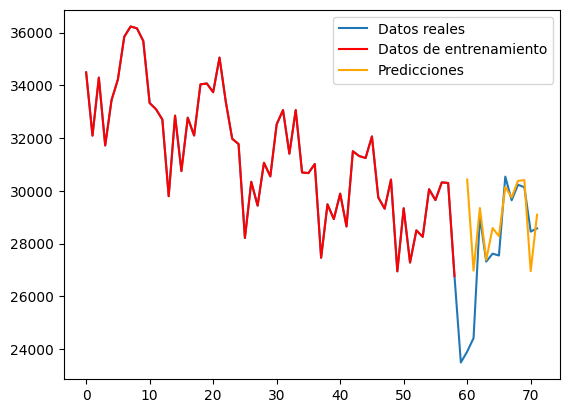

In [ ]:
# SARIMAX

# Definimos los periodos de tiempo faltantes
T_missing = range(60, 72)

# Obtenemos los datos como un array NumPy
X = suma_pais["count"].to_numpy()

# Dividimos los datos en entrenamiento y prueba
X_train = suma_pais['count'][:59]
X_test = X[60:72]

# Creamos el modelo ARIMA
model1 = SARIMAX(X_train,seasonal_order=(1,1,0,12))
model_fit1 = model1.fit()

# Realizamos predicciones para los periodos faltantes
X_hat_series = model_fit1.predict(start=T_missing[0], end=T_missing[-1], dynamic=True)

# Graficamos los resultados
plt.plot(X, label='Datos reales')
plt.plot(X_train, color='red', label='Datos de entrenamiento')
plt.plot(T_missing, X_hat_series, color='orange', label='Predicciones')
plt.legend()

# Mostramos la figura
plt.show()

In [ ]:
arma_mae = mean_absolute_error(X[T_missing], X_hat_series)
print(arma_mae)

1176.4954546163415


In [ ]:
r2 = r2_score(X[T_missing], X_hat_series)
print(r2)

-0.05811346903685255


 Aunque el MAE más bajo en SARIMAX indica un mejor rendimiento en términos de precisión, el r2 negativo podría ser una señal de que el modelo no está explicando bien la variabilidad de los datos.

Ya que tenemos el modelo entrenado con sarimax para los valores sin contar 2021 lo aplicamos para predecir 2022
A partir de esta celda dejamos de comentar el código ya que es siempre el mismo proceso, entrenar el modelo y hacer un predict.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


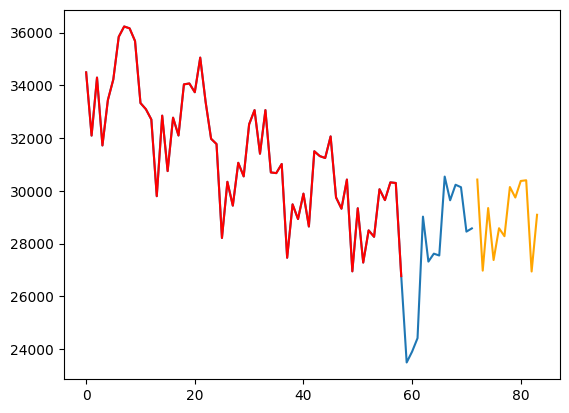

In [ ]:
T_missing = range(72, 84)
X_hat_series = model_fit1.predict(start=T_missing[0],end=T_missing[-1],dynamic=True)

plt.plot(X)
plt.plot(X_train, color='red')
plt.plot(T_missing, X_hat_series, color='orange')

Para comprobar que lo haga bien a futuro predecimos hasta el año 2026.

In [ ]:
T_missing = range(72, 196)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


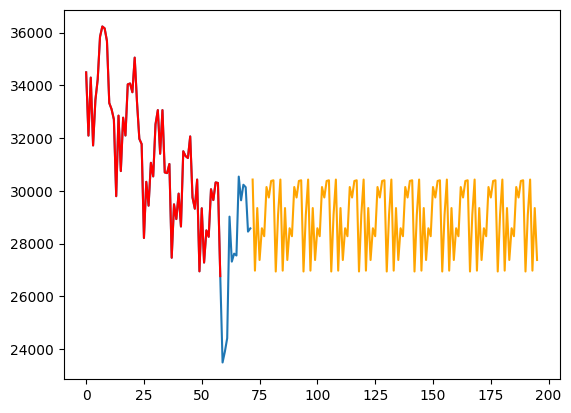

In [ ]:
model1 = SARIMAX(X_train,seasonal_order=(1,1,0,12))
model_fit1 = model1.fit()


X_hat_series = model_fit1.predict(start=T_missing[0],end=T_missing[-1],dynamic=True)

plt.plot(X)
plt.plot(X_train, color='red')
plt.plot(T_missing, X_hat_series, color='orange')

No se ven muy buenos resultados así que probamos con ARIMA

Volvemos a entrenar el modelo

In [ ]:
T_missing = range(72, 196)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


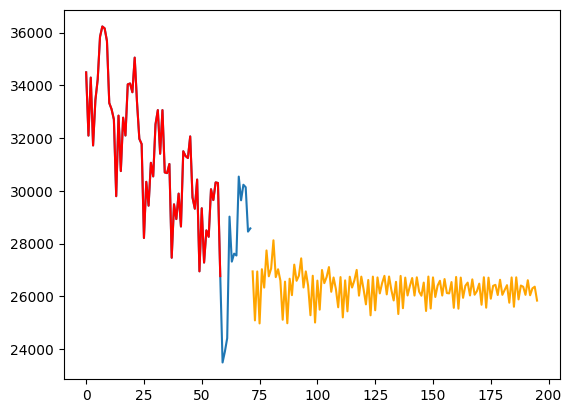

In [ ]:
model1 = ARIMA(X_train, order=(25, 1, 5))
model_fit1 = model1.fit()


X_hat_series = model_fit1.predict(start=T_missing[0],end=T_missing[-1],dynamic=True)

plt.plot(X)
plt.plot(X_train, color='red')
plt.plot(T_missing, X_hat_series, color='orange')

Tampoco se ve muy esperanzador, probamos con ARMA

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


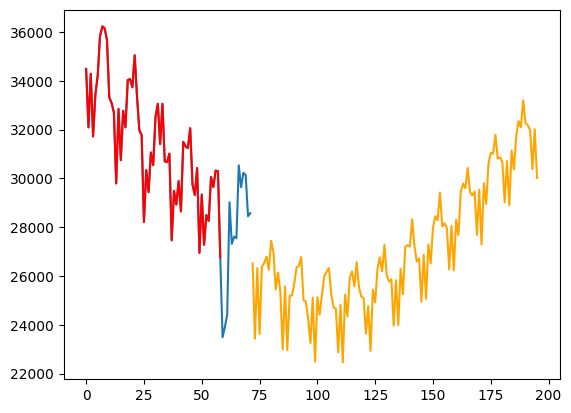

In [ ]:
model1 = ARIMA(X_train, order=(25, 0, 5))
model_fit1 = model1.fit()


X_hat_series = model_fit1.predict(start=T_missing[0],end=T_missing[-1],dynamic=True)

plt.plot(X)
plt.plot(X_train, color='red')
plt.plot(T_missing, X_hat_series, color='orange')

Los resultados tienen sentido ya que cumplen lo que hemos visto anteriormente, que las cantidades de nacimientos irán disminuyendo con el paso de los años. Pero este modelo estaba entrenado sin los valores de 2021, así que ahora para un análisis más completo incluiremos los valores de 2021 en el fit.

Nuestro conjunto de entrenamiento serán por tanto todos los valores de los que disponemos.

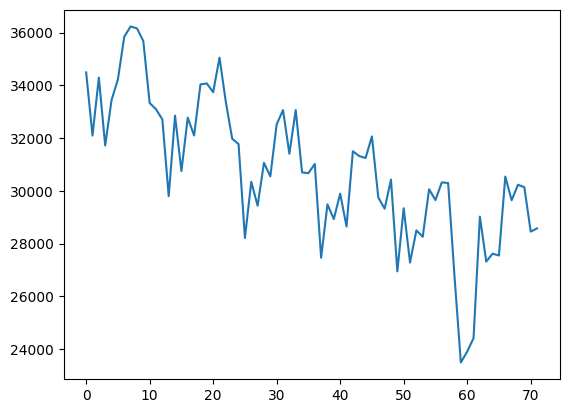

In [ ]:
X_train = suma_pais["count"]


T_missing = range(72, 84)

plt.plot(X_train)
plt.show()

Entrenamos el modelo y predecimos 2022.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


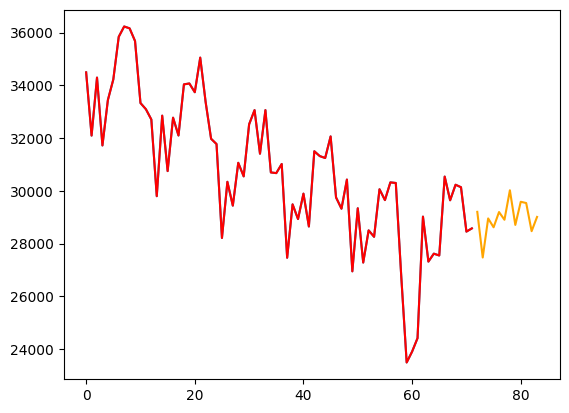

In [ ]:
model1 = ARIMA(X_train, order=(25, 1, 5))
model_fit1 = model1.fit()


X_hat_series = model_fit1.predict(start=T_missing[0],end=T_missing[-1],dynamic=True)

plt.plot(X)
plt.plot(X_train, color='red')
plt.plot(T_missing, X_hat_series, color='orange')

Con los datos hasta 2021 hace una predición razonable pero no podemos asegurar la validez de este fit ya que no tenemos datos de test.

Para comprobar el entrenamiento hacemos una predicción hasta 2030 al igual que antes.

In [ ]:
T_missing = range(72, 196)

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


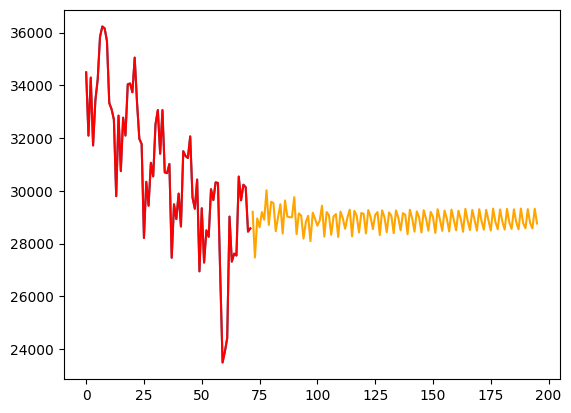

In [ ]:
model1 = ARIMA(X_train, order=(25,1,5))
model_fit1 = model1.fit()


X_hat_series = model_fit1.predict(start=T_missing[0],end=T_missing[-1],dynamic=True)

plt.plot(X)
plt.plot(X_train, color='red')
plt.plot(T_missing, X_hat_series, color='orange')

Vemos que no sale bien la predicción hasta 2030, como hemos dicho este entrenamiento no ha contado con un dataset de test para validar los resultados del fit. Por tanto la mejor manera de predecir los datos de 2022 es usar el entrenamiento que no incluye 2021 en train ya que de esta manera si que podemos validar el entrenamiento, mientras que añadiendo 2021 en train no podemos asegurar que el modelo sea correcto.

ARIMA ejemplo de clase

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels

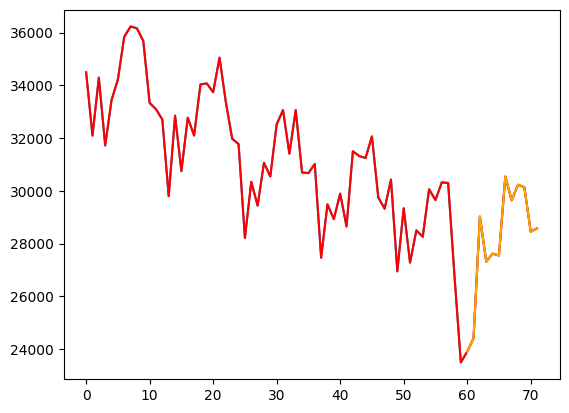

In [ ]:
X = suma_pais["count"].to_numpy()
X_full = suma_pais['count']
X_hat_series = X

T_missing = range(60,72)
for t in T_missing:
    series = X
    model = ARIMA(X_full[:t], order=(5,1,2))
    model_fit = model.fit()
    X_hat_series = np.hstack((X_hat_series, model_fit.predict(start=t,end=t,dynamic=True)))

plt.plot(X_full)
plt.plot(X, color='red')
plt.plot(T_missing, X_hat_series[T_missing], color='orange')
plt.show()


In [ ]:
mean_absolute_error(X_full[T_missing], X_hat_series[T_missing])

0.0

Al hacer un for t in T_missing para el fit está aprendiendo los valores que tendrá que predecir, por tanto hay overfitting y teneos un mae de 0. Es por ello que para evitar este overfitting hemos optado por no usar ese for que añade al entrenamiento los resutados a predecir.

Hecemos una predicción en base al sexo, para ver como afecta el sexo al nacimiento del país.

Primero enseñamos el total de mujeres y luego el de hombres, ambos por mes en todo el país.

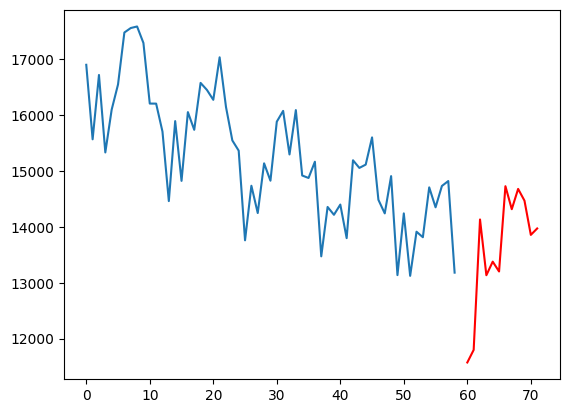

In [ ]:
X = total_mujeres["count"]
X_train = X[:59]
X_test = X[60:total_mujeres.shape[0]]

T_missing = range(60, 72)


plt.plot(X_train)
plt.plot(X_test, color='red')
plt.show()

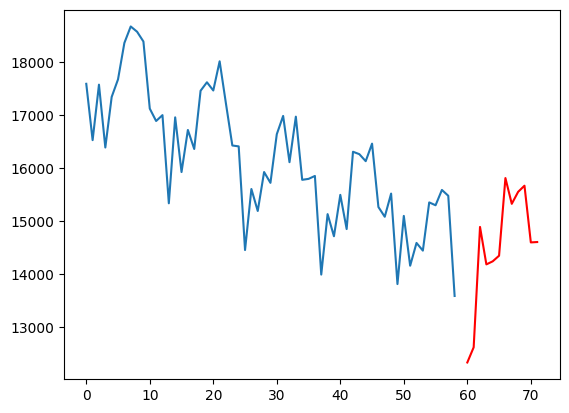

In [ ]:
X = total_varones["count"]
X_train = X[:59]
X_test = X[60:total_varones.shape[0]]

T_missing = range(60, 72)

plt.plot(X_train)
plt.plot(X_test, color='red')
plt.show()

Luego entrenamos el modelo para cada uno

Mujeres:

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


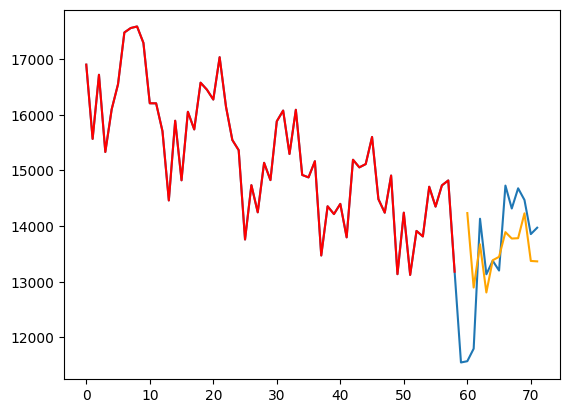

In [ ]:
# ARIMA

T_missing = range(60, 72)
X = total_mujeres["count"].to_numpy()
X_train = total_mujeres['count'][:59]
X_test = X[60:72]

model1 = ARIMA(X_train, order=(25,1,5))
model_fit1 = model1.fit()


X_hat_series = model_fit1.predict(start=T_missing[0],end=T_missing[-1],dynamic=True)

plt.plot(X)
plt.plot(X_train, color='red')
plt.plot(T_missing, X_hat_series, color='orange')

In [ ]:
arma_mae = mean_absolute_error(X[T_missing], X_hat_series)
print(arma_mae)

700.3034241556393


En mujeres MAE de 700 en valores que alcanzan 17.000 así que representa un 4%, lo damos por válido.

Varones:

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


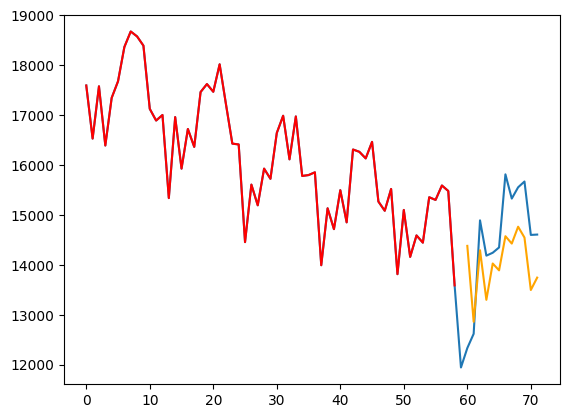

In [ ]:
# ARIMA

T_missing = range(60, 72)
X = total_varones["count"].to_numpy()
X_train = total_varones['count'][:59]
X_test = X[60:72]

model1 = ARIMA(X_train, order=(25,1,5))
model_fit1 = model1.fit()


X_hat_series = model_fit1.predict(start=T_missing[0],end=T_missing[-1],dynamic=True)

plt.plot(X)
plt.plot(X_train, color='red')
plt.plot(T_missing, X_hat_series, color='orange')

In [ ]:
arma_mae = mean_absolute_error(X[T_missing], X_hat_series)
print(arma_mae)

871.9036463530969


En varones MAE de 872 en valores que alcanzan 19.000 así que representa un 4.58%, lo damos por válido.


Hacemos la predicción para 2022 de mujeres y varones (hay que hacer run de todo lo de mujeres y luego sobre todo lo de varones para que salga bien)

Mujeres:

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


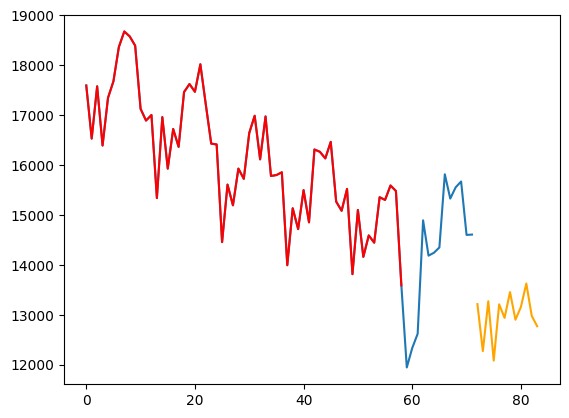

In [ ]:
T_missing = range(72, 84)
X_hat_series = model_fit1.predict(start=T_missing[0],end=T_missing[-1],dynamic=True)

plt.plot(X)
plt.plot(X_train, color='red')
plt.plot(T_missing, X_hat_series, color='orange')

Varones:

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


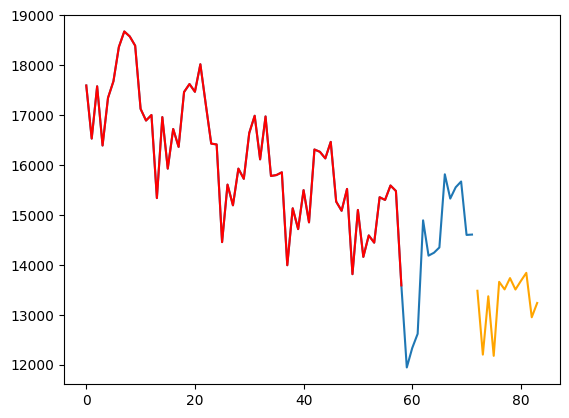

In [ ]:
T_missing = range(72, 84)
X_hat_series = model_fit1.predict(start=T_missing[0],end=T_missing[-1],dynamic=True)

plt.plot(X)
plt.plot(X_train, color='red')
plt.plot(T_missing, X_hat_series, color='orange')

Concluimos que tanto varones como mujeres de todo el país han tenido una decadencia en número de nacimientos con el paso de los años. Con esto hemos analizado por sexo. Para llegar a la mayor profundidad lo analizaremos por provincias, de esta manera podremos ver si hay alguna que no tenga esta evolución decadente.

Vamos a hacer una predicción por cada una de las provincias del dataset y cada uno de los sexos.

Una vez tengamos esto los uniremos en un mismo dataset y sumaremos los datos de los géneros y de las mismas fechas para poder representarlo de forma más visual como hemos hecho anteriormente. De esta manera habremos predicho los resultados para cada provincia y cada sexo pero visualizaremos su suma como un total del país.

Definimos una nueva funcion transformar_dataframe3 que se diferencia de la anterior en que se ordena el dataframe en base a la fecha, para que empiece en 2016.

In [ ]:
def transformar_dataframe3(df):
    # Crear la columna 'fecha' combinando 'año' y 'mes'
    df['fecha'] = pd.to_datetime(df['ANOPAR'].astype(str) + df['MESPAR'].astype(str).str.zfill(2), format='%Y%m')
    df = df.sort_values(by='fecha')
    df.reset_index(drop=True, inplace=True)
    # Convertir 'fecha' a tipo object (cadena de caracteres)
    df['fecha'] = df['fecha'].astype('str')

    # Seleccionar las columnas relevantes
    nuevo_df = df[['fecha', 'count']]
    return nuevo_df

In [ ]:
a = crear_provincia(1,varon)
b = crear_provincia(1,mujer)
a = transformar_dataframe3(a)
b = transformar_dataframe3(b)
a

fecha  count
0   2016-01-01    147
1   2016-02-01    116
2   2016-03-01    124
3   2016-04-01    102
4   2016-05-01    136
..         ...    ...
67  2021-08-01     93
68  2021-09-01    114
69  2021-10-01    103
70  2021-11-01    108
71  2021-12-01    117

[72 rows x 2 columns]

Plot de hombres y mujeres en provincia 1

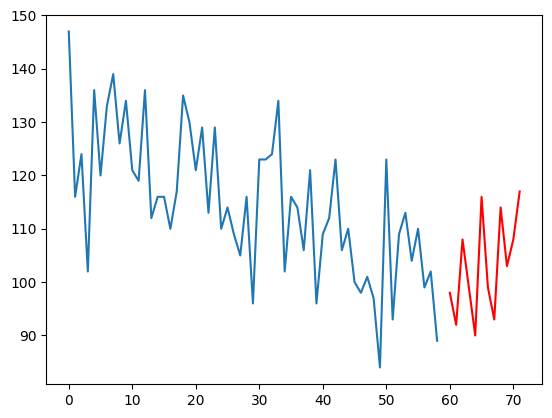

In [ ]:
X = a["count"]
X_train = X[:59]
X_test = X[60:72]

T_missing = range(60, 72)

plt.plot(X_train)
plt.plot(X_test, color='red')
plt.show()

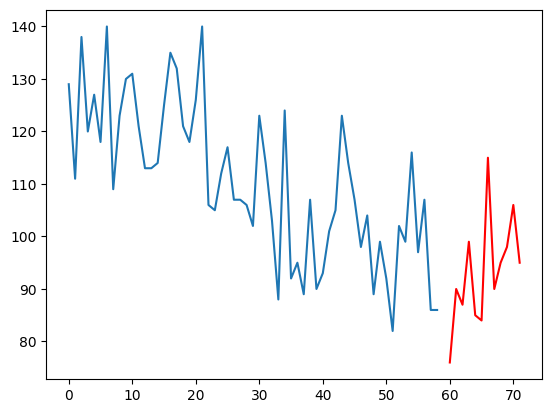

In [ ]:
X = b["count"]
X_train = X[:59]
X_test = X[60:72]

T_missing = range(60, 72)

plt.plot(X_train)
plt.plot(X_test, color='red')
plt.show()

Predicción hombres y mujeres provincia 1

Hombres:

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


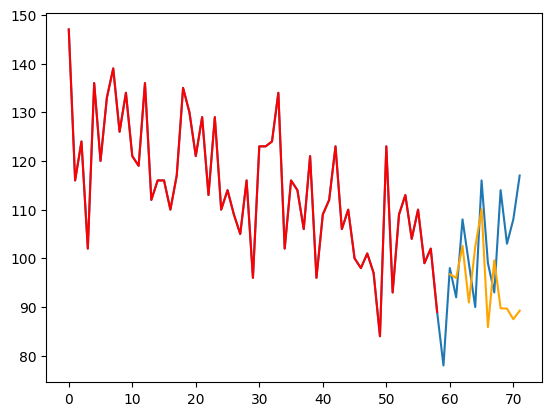

In [ ]:
# ARIMA

T_missing = range(60, 72)
X = a["count"].to_numpy()
X_train = a['count'][:59]
X_test = X[60:72]

model1 = ARIMA(X_train, order=(25,1,5))
model_fit1 = model1.fit()


X_hat_series = model_fit1.predict(start=T_missing[0],end=T_missing[-1],dynamic=True)

plt.plot(X)
plt.plot(X_train, color='red')
plt.plot(T_missing, X_hat_series, color='orange')

In [ ]:
arma_mae = mean_absolute_error(X[T_missing], X_hat_series)
print(arma_mae)

11.873074329974605


MAE de 11 en datos de 150.

mujeres:

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


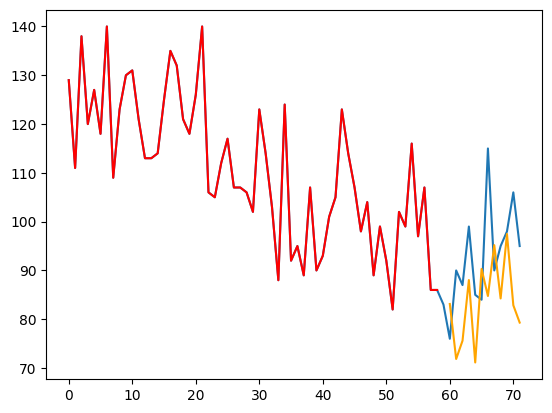

In [ ]:
# ARIMA

T_missing = range(60, 72)
X = b["count"].to_numpy()
X_train = b['count'][:59]
X_test = X[60:72]

model1 = ARIMA(X_train, order=(25,1,5))
model_fit1 = model1.fit()


X_hat_series = model_fit1.predict(start=T_missing[0],end=T_missing[-1],dynamic=True)

plt.plot(X)
plt.plot(X_train, color='red')
plt.plot(T_missing, X_hat_series, color='orange')

In [ ]:
arma_mae = mean_absolute_error(X[T_missing], X_hat_series)
print(arma_mae)

12.777876501956024


Predicción mujeres 2022 en provincia 1

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


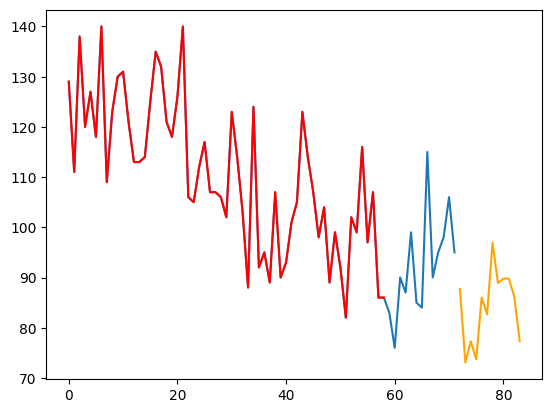

In [ ]:
T_missing = range(72, 84)
X_hat_series = model_fit1.predict(start=T_missing[0],end=T_missing[-1],dynamic=True)

plt.plot(X)
plt.plot(X_train, color='red')
plt.plot(T_missing, X_hat_series, color='orange')

Predición 2022 hombres en provincia 1

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


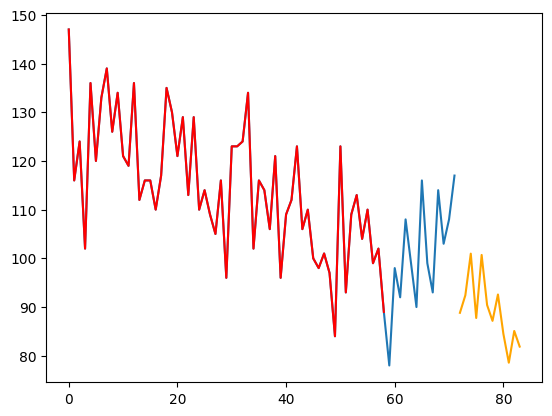

In [ ]:
T_missing = range(72, 84)
X_hat_series = model_fit1.predict(start=T_missing[0],end=T_missing[-1],dynamic=True)

plt.plot(X)
plt.plot(X_train, color='red')
plt.plot(T_missing, X_hat_series, color='orange')

Hacemos un código que se queda con los valores de las predicciones de 2021 y 2022 para varones y mujeres de una provincia en específico, más adelante nos será útil para hacer esto con cada provincia y sumar todos los resultados para poder analizar los resultados a nivel de país para comparar con los datos anteriores y ver si las predicciones a nivel de provincia han sido acertadas.

In [ ]:
#valores a predecir 2021
T_missing = range(60, 72)
# valores a predecir 2022
T_missing_2022 = range(72,84)

#dataset varon y mujer de cada provincia.
a = crear_provincia(1,varon)
b = crear_provincia(1,mujer)
a = transformar_dataframe2(a)
b = transformar_dataframe2(b)

X = a["count"].to_numpy()
X_train = a['count'][:59]
X_test = X[60:72]
model1 = ARIMA(X_train, order=(25,1,5))
model_fit1 = model1.fit()
X_hat_series_a2021 = model_fit1.predict(start=T_missing[0],end=T_missing[-1],dynamic=True)
X_hat_series_a2022 = model_fit1.predict(start=T_missing_2022[0],end=T_missing_2022[-1],dynamic=True)


X = b["count"].to_numpy()
X_train = b['count'][:59]
X_test = X[60:72]
model1 = ARIMA(X_train, order=(25,1,5))
model_fit1 = model1.fit()
X_hat_series_b2021 = model_fit1.predict(start=T_missing[0],end=T_missing[-1],dynamic=True)
X_hat_series_b2022 = model_fit1.predict(start=T_missing_2022[0],end=T_missing_2022[-1],dynamic=True)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Che

Plot de la provincia 1 para varones y mujeres (comprimimos lo anterior en una sola celda para poder meterlo en un bucle for y próximamente hacerlo con todas las povincias)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.

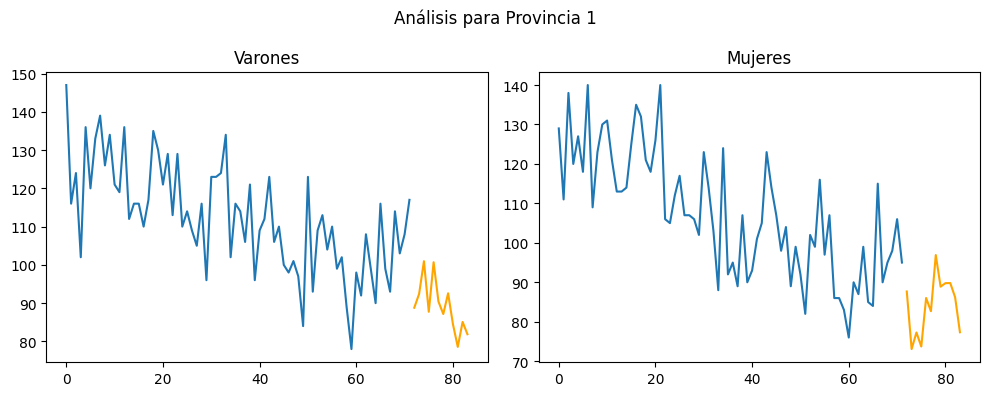

In [ ]:
a = crear_provincia(1,varon)
b = crear_provincia(1,mujer)
a = transformar_dataframe3(a)
b = transformar_dataframe3(b)

X1 = a["count"]
X_train_varon = X1[:59]
X_test_varon = X1[60:72]



X2 = b["count"]
X_train_mujer = X2[:59]
X_test_mujer = X2[60:72]

T_missing = range(72, 84)

model_varon = ARIMA(X_train_varon, order=(25,1,5))
model_fit_varon = model_varon.fit()
X_hat_series_varon = model_fit_varon.predict(start=T_missing[0],end=T_missing[-1],dynamic=True)

model_mujer = ARIMA(X_train_mujer, order=(25,1,5))
model_fit_mujer = model_mujer.fit()
X_hat_series_mujer = model_fit_mujer.predict(start=T_missing[0],end=T_missing[-1],dynamic=True)

plt.figure(figsize = (10,4))

plt.subplot(1,2,1)
plt.plot(X1)
#plt.plot(X_train_varon, color='red')
plt.plot(T_missing, X_hat_series_varon, color='orange')
plt.title('Varones')
plt.subplot(1,2,2)
plt.plot(X2)
#plt.plot(X_train_mujer, color='red')
plt.plot(T_missing, X_hat_series_mujer, color='orange')
plt.title('Mujeres')

plt.suptitle('Análisis para Provincia 1')
plt.tight_layout()
plt.show()

Plot de las 52 provincias tanto para varones como para mujeres

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.

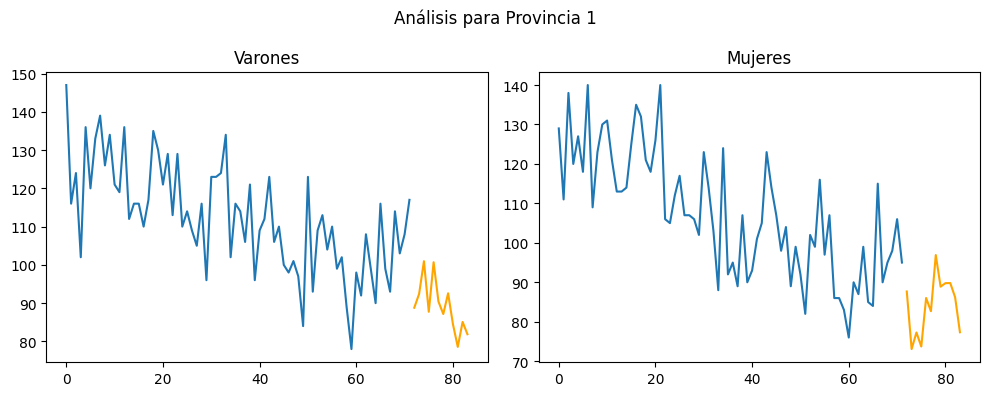

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.

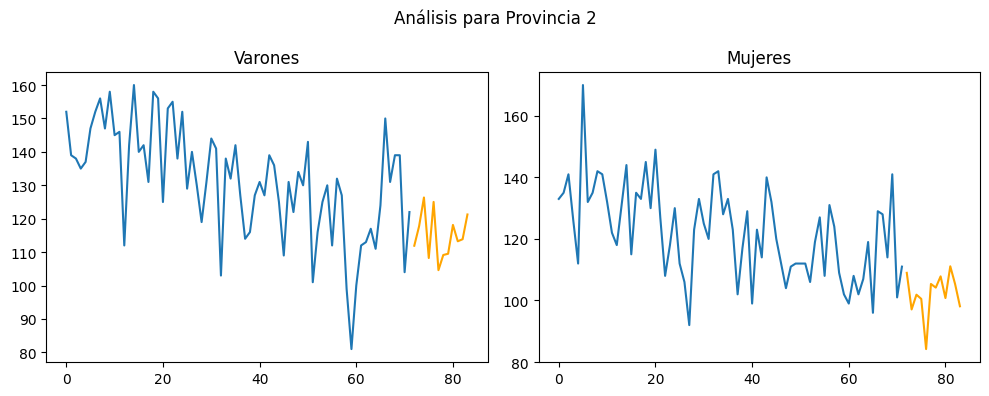

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
/usr/local/lib/python3.10/dist-packages/

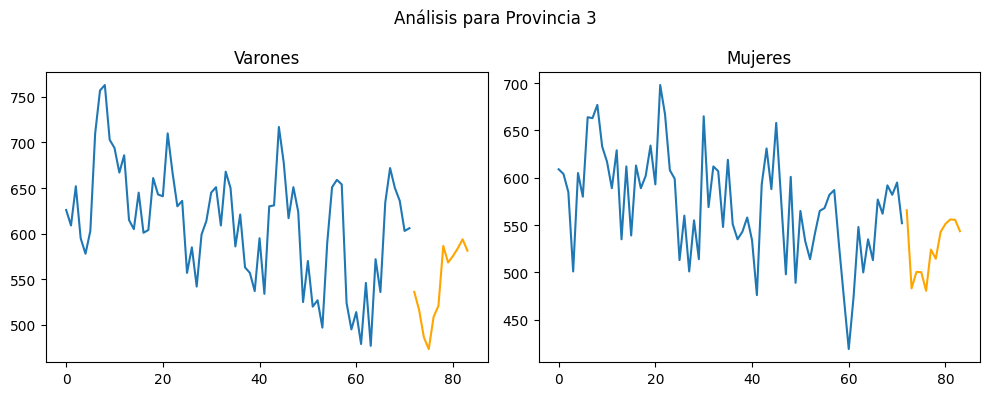

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.

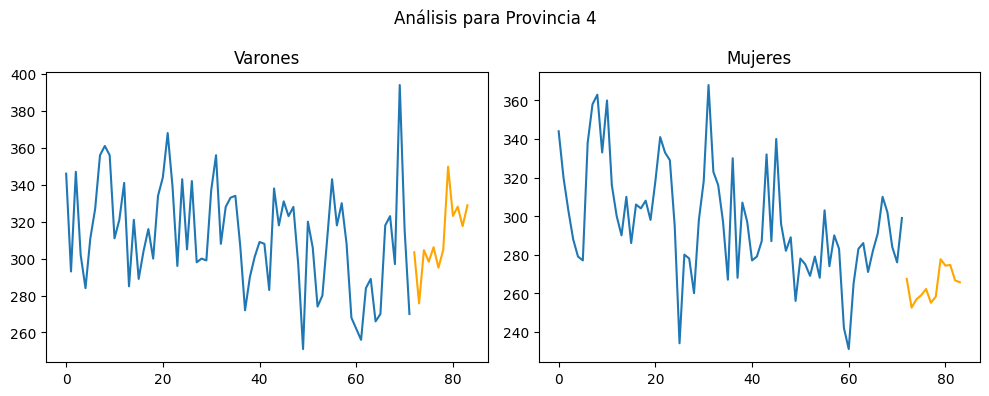

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.

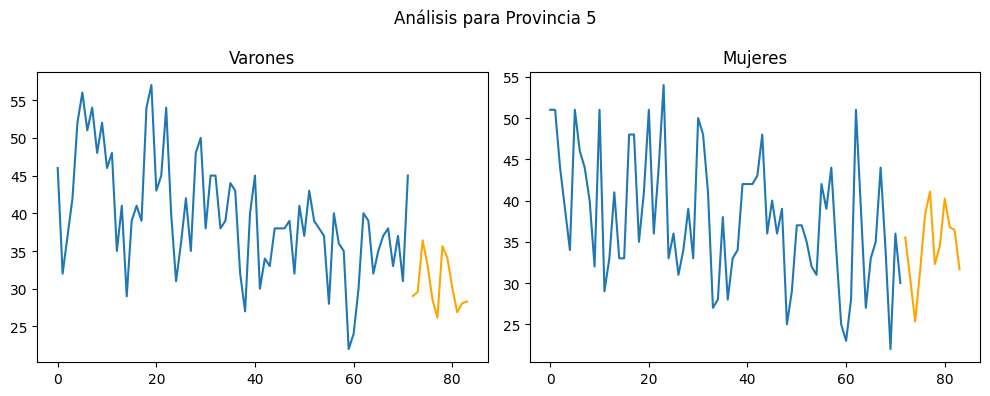

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
/usr/local/lib/python3.10/dist-packages/

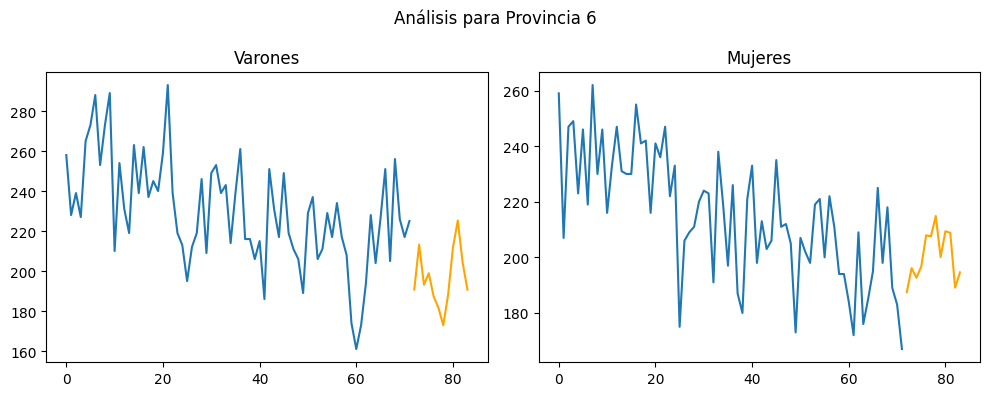

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.

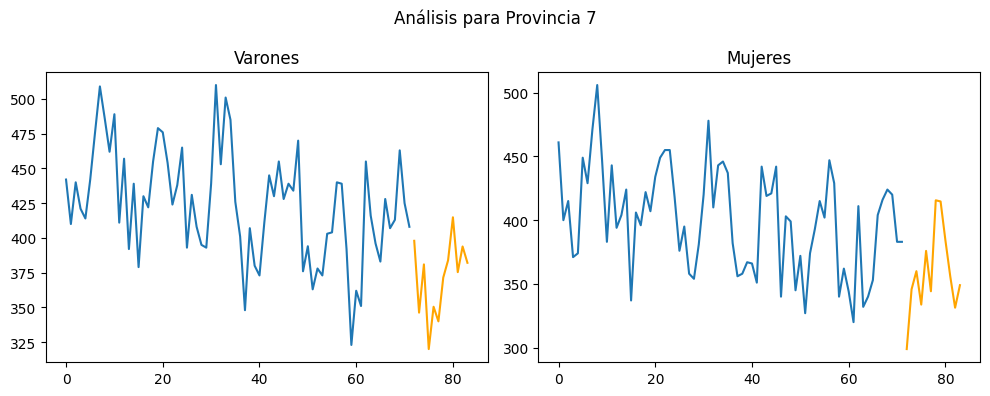

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.

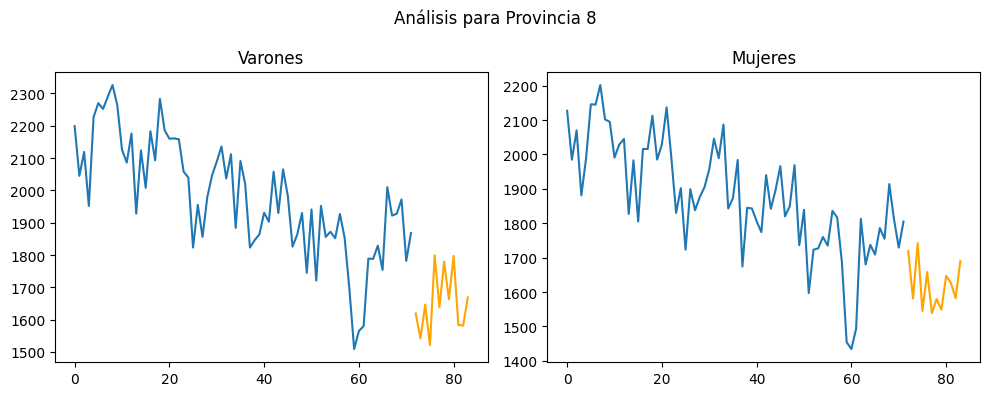

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
/usr/local/lib/python3.10/dist-packages/

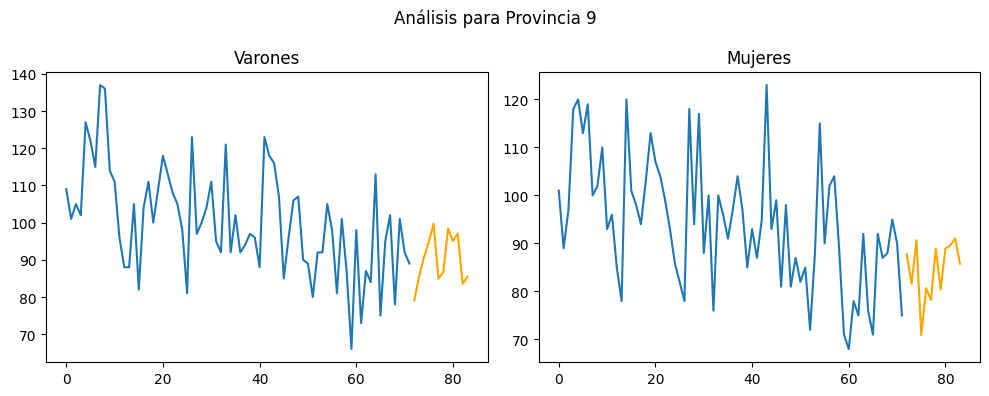

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmode

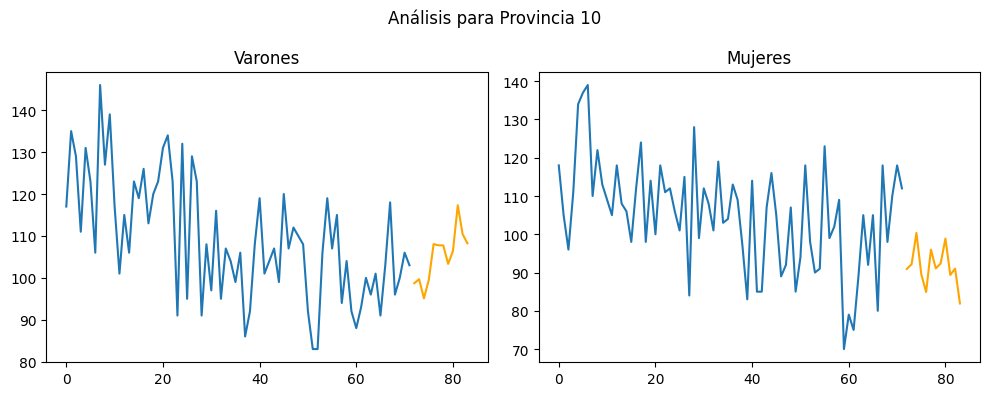

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.

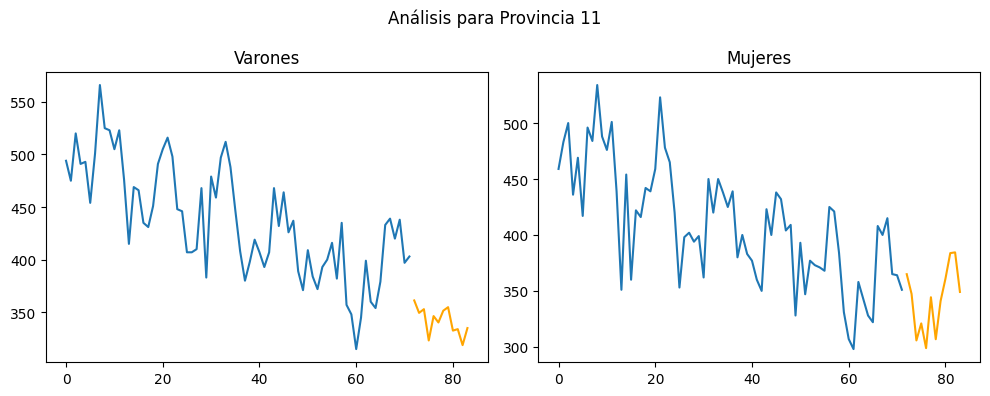

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.

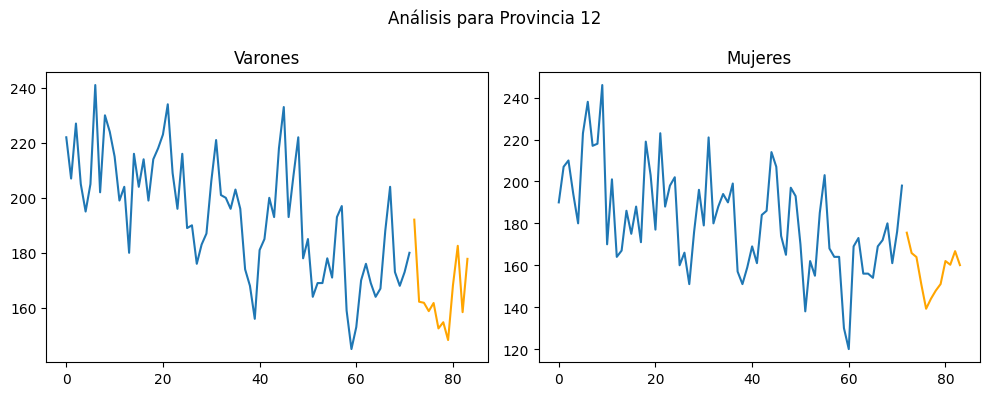

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.

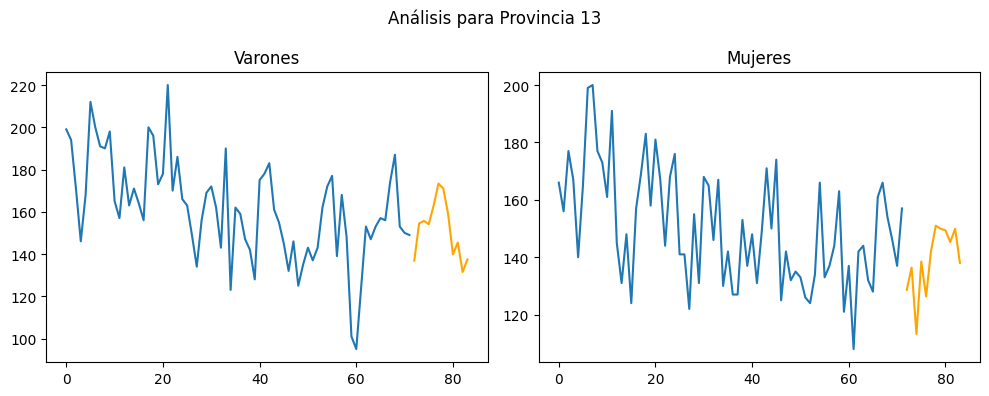

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.

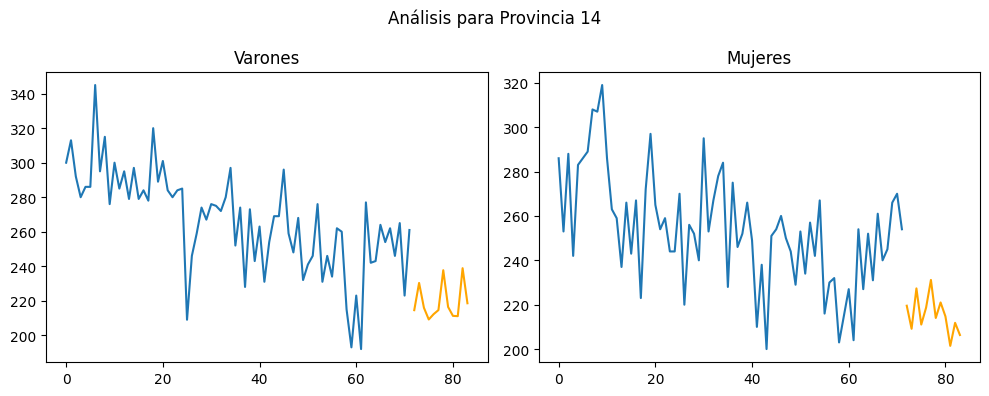

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.

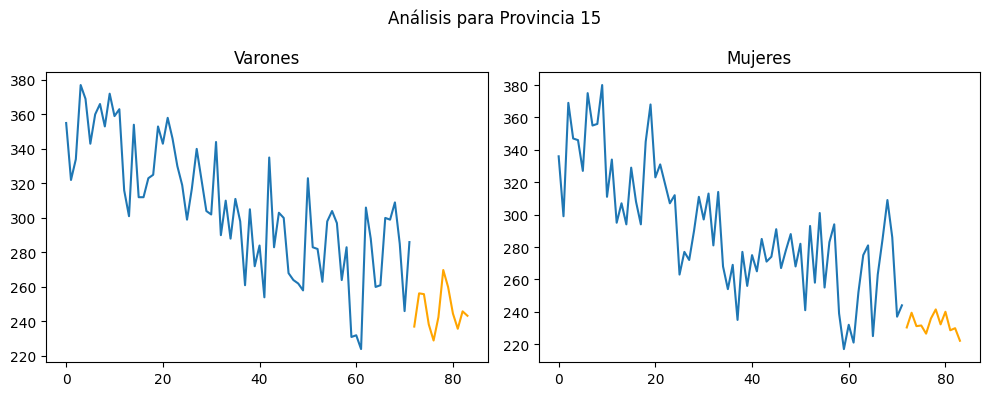

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmode

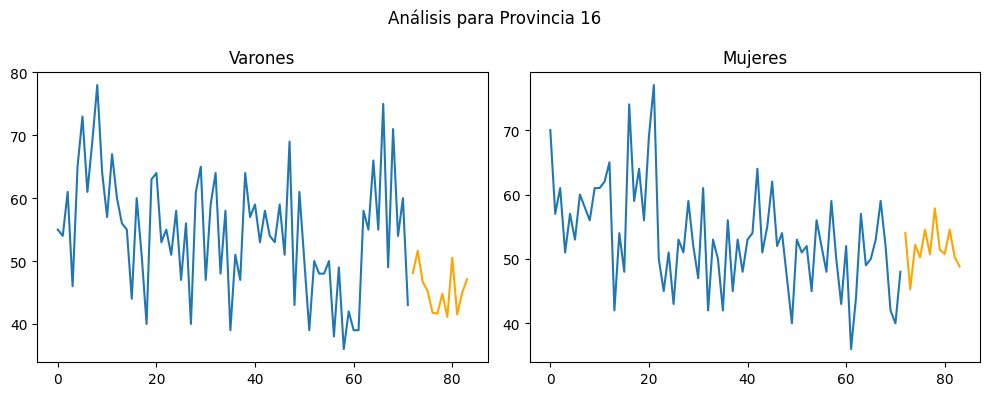

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
/usr/local/lib/python3.10/dist-packages/

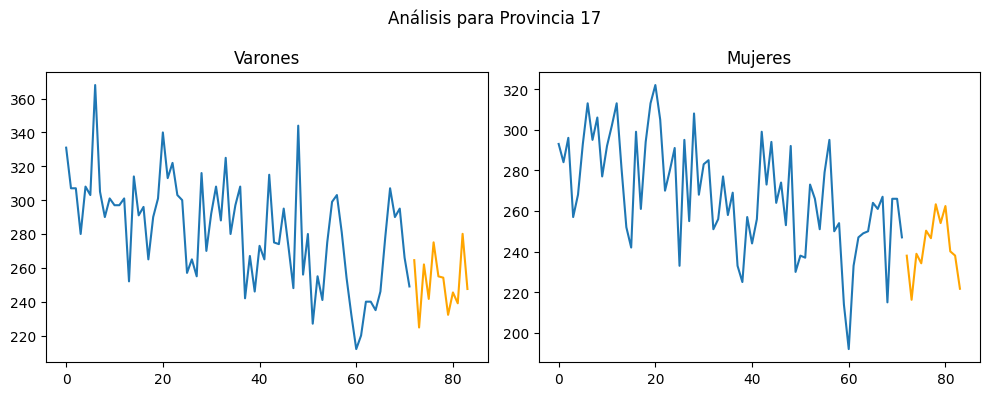

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
/usr/local/lib/python3.10/dist-packages/

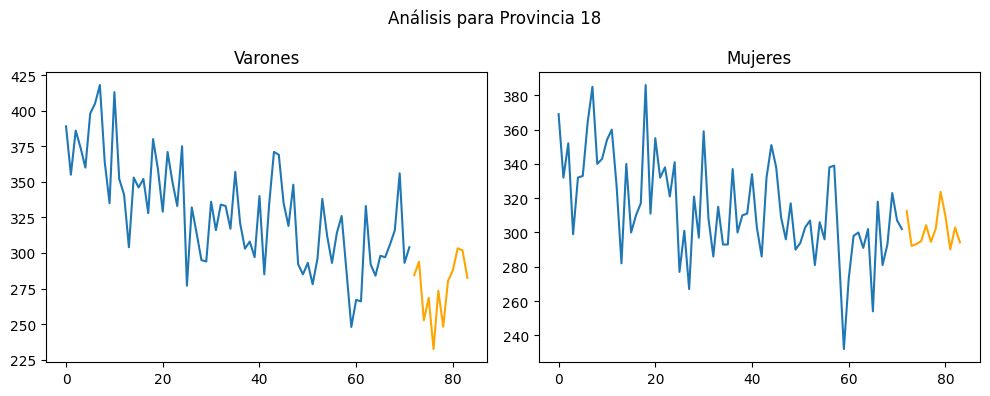

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.

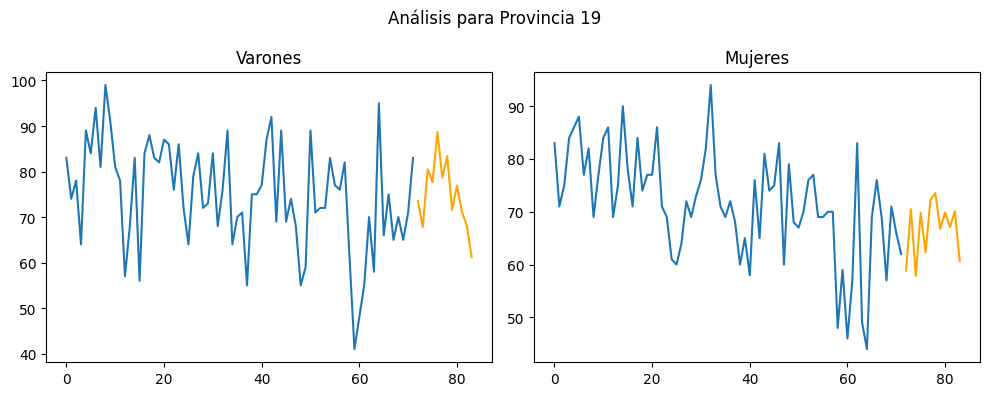

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.

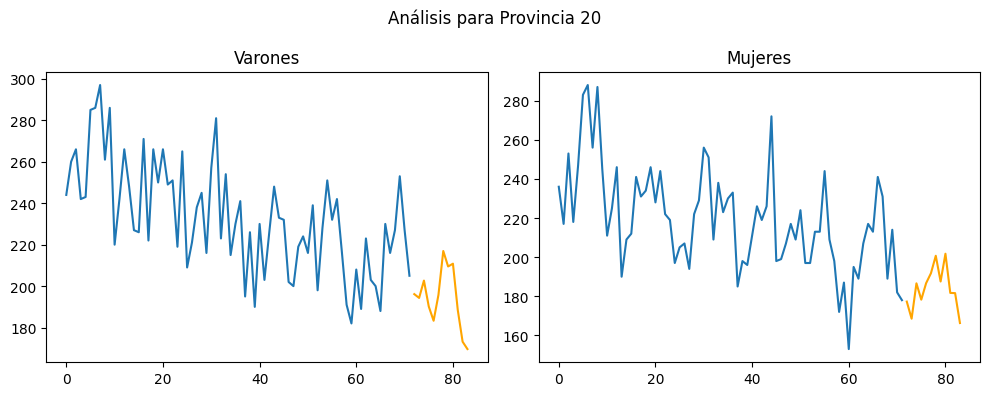

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.

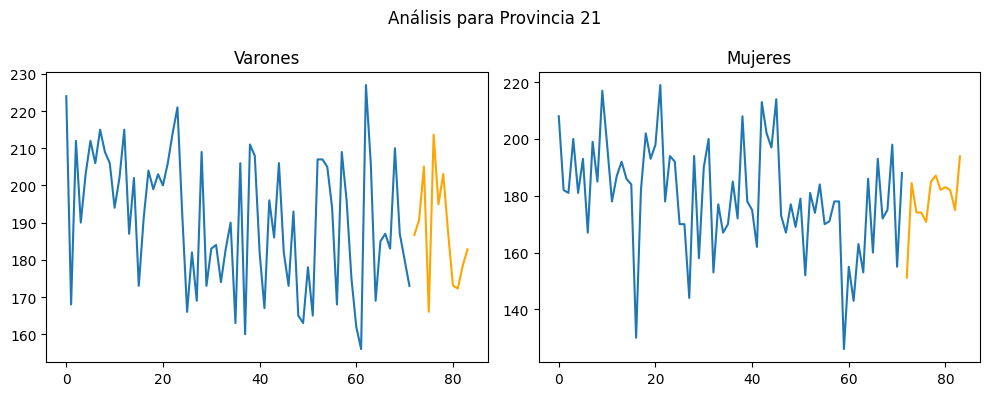

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.

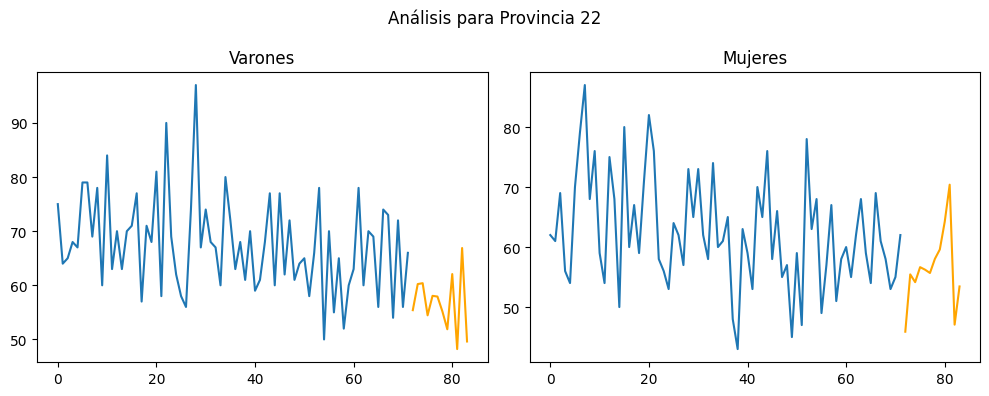

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.

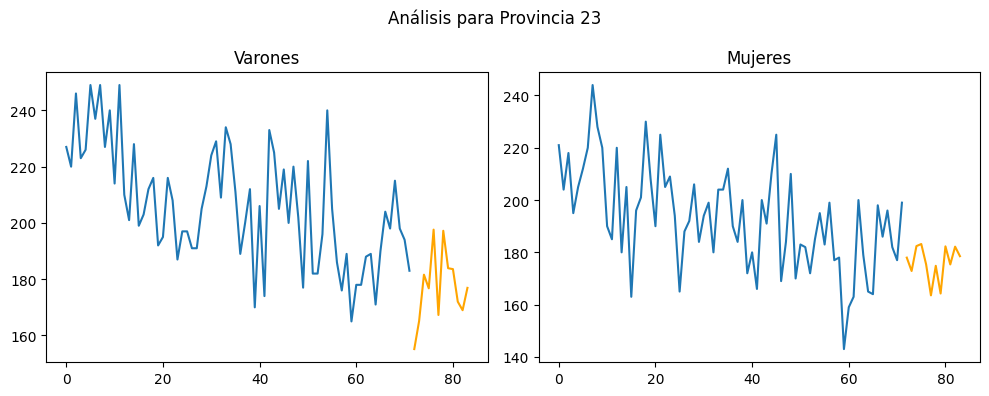

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.

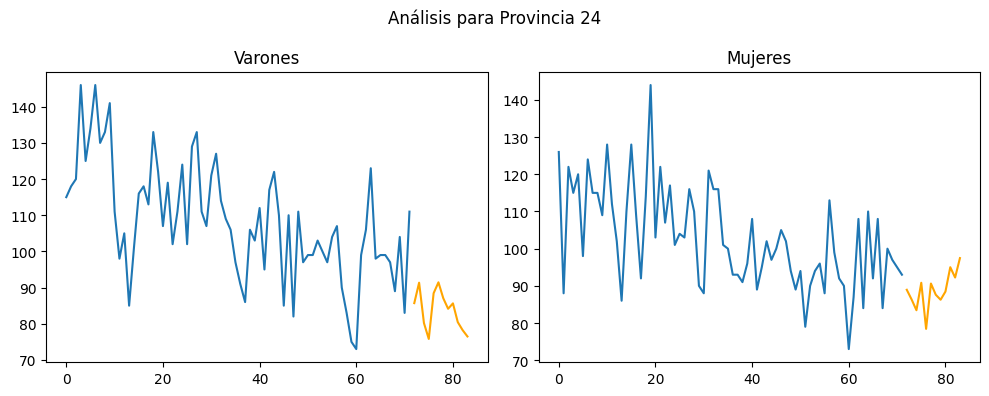

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.

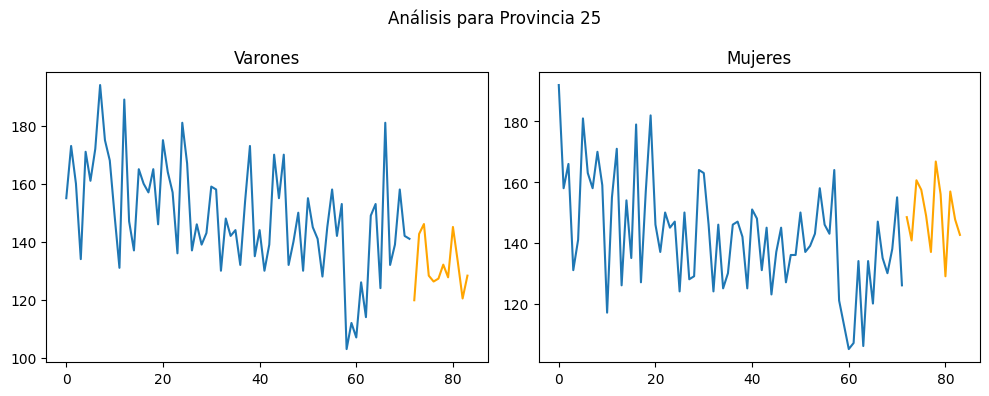

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.

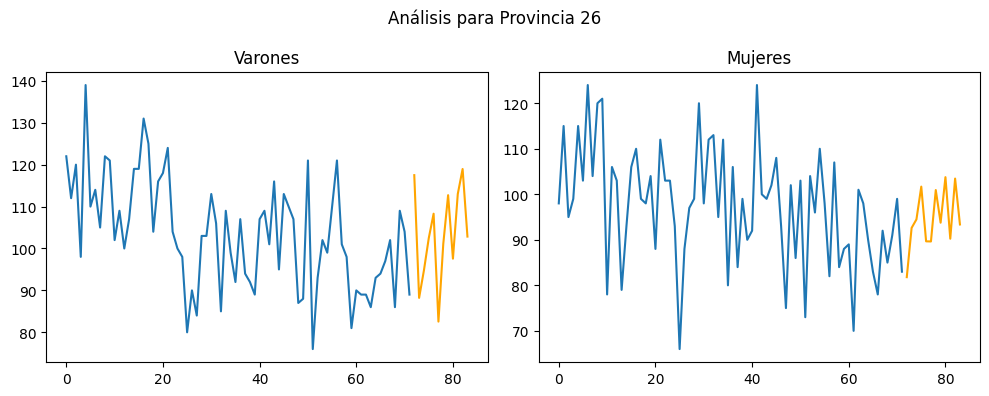

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.

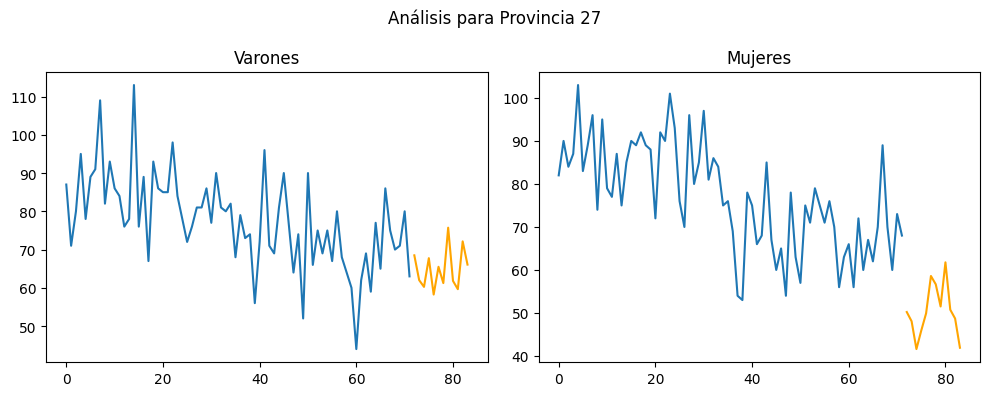

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.

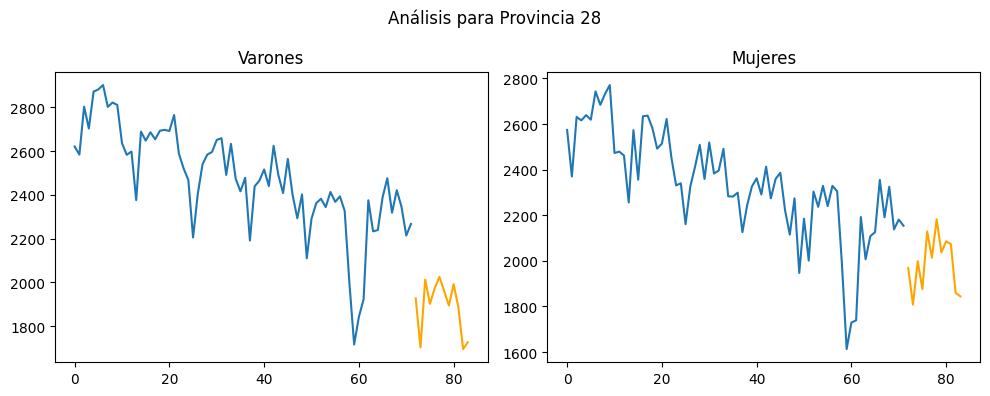

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.

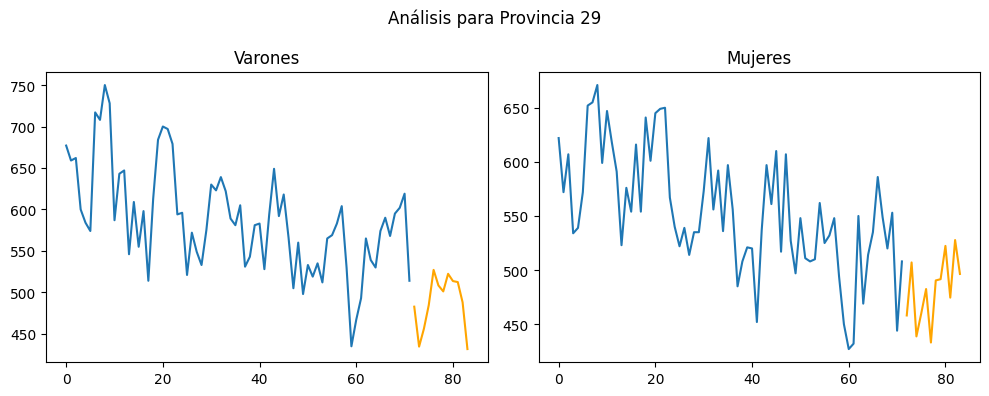

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.

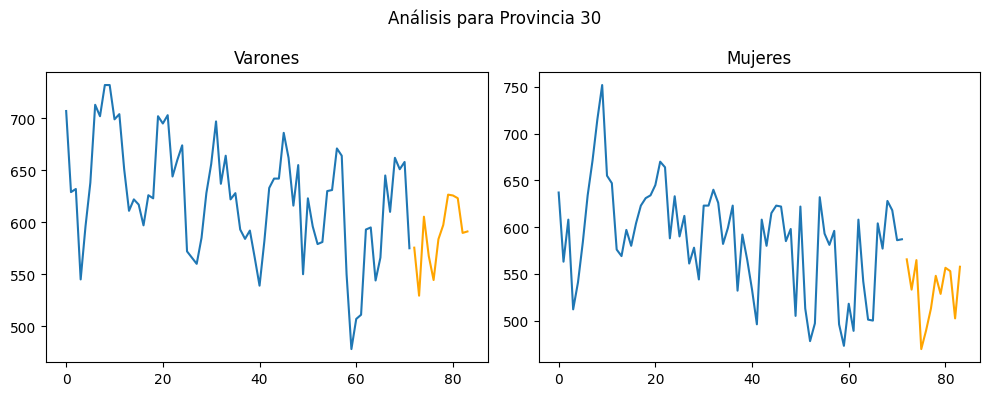

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.

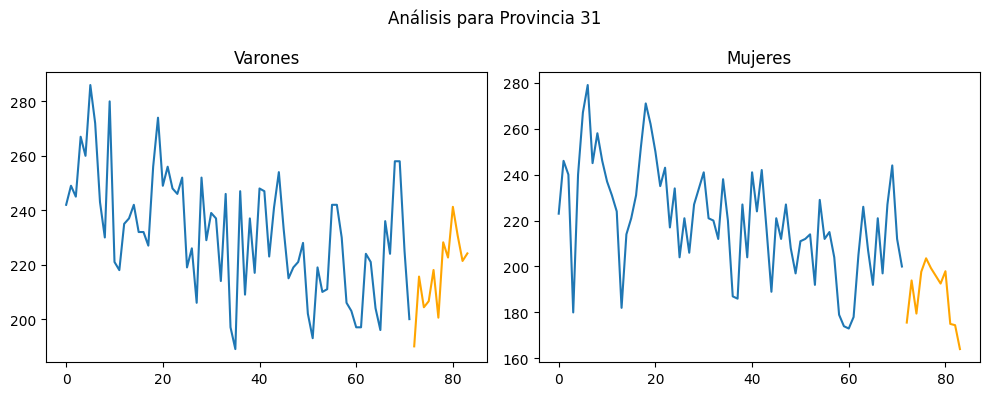

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.

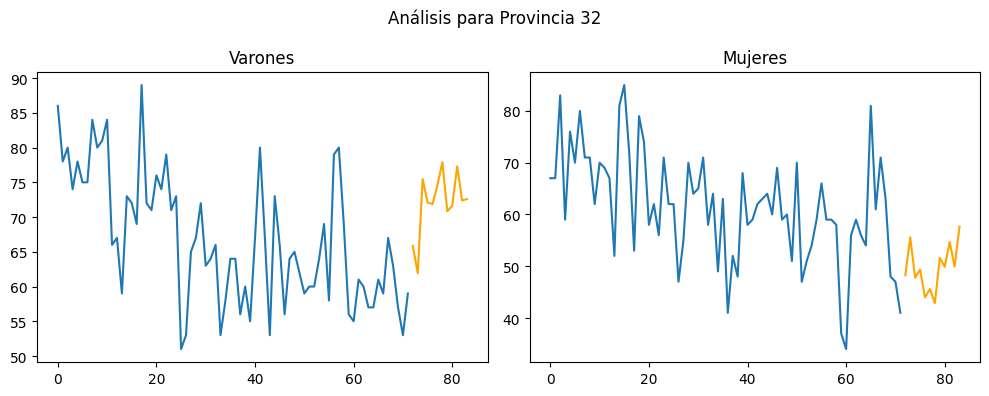

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.

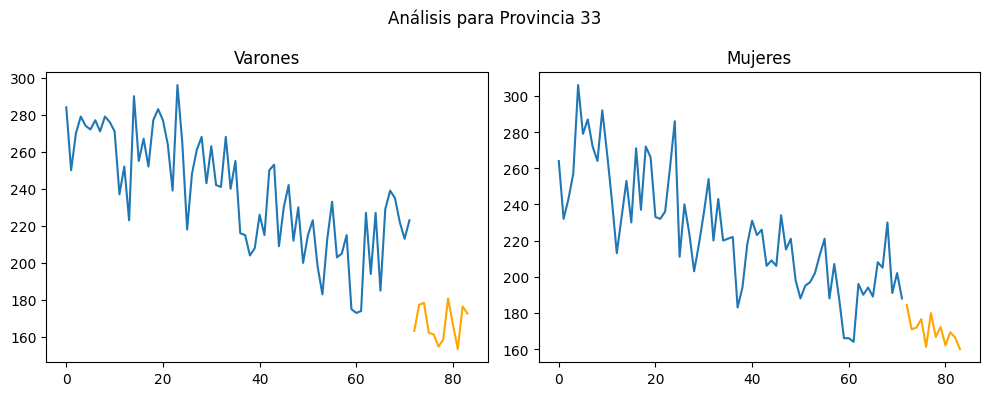

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.

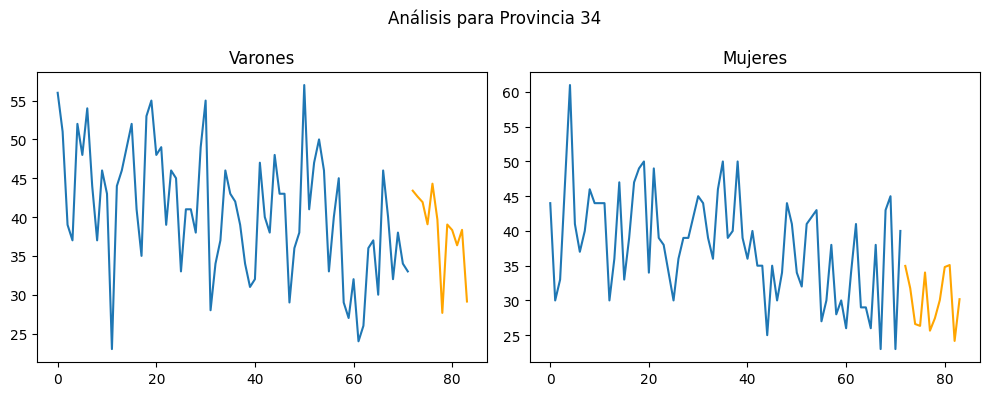

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
/usr/local/lib/python3.10/dist-packages/

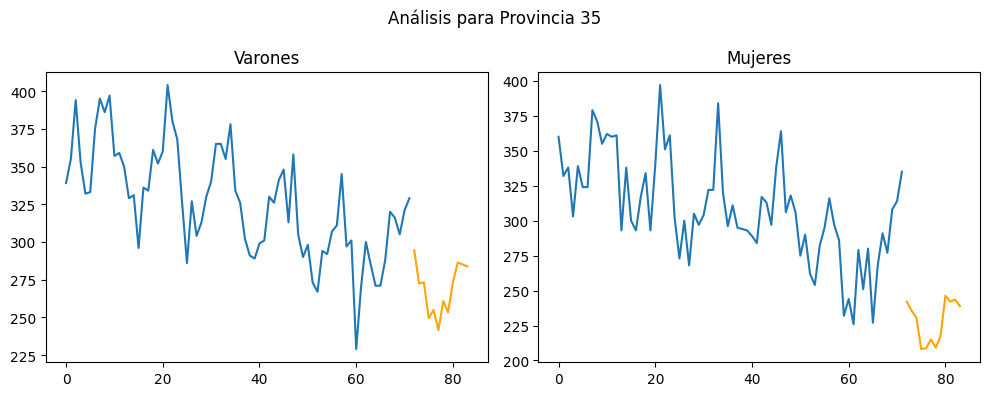

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.

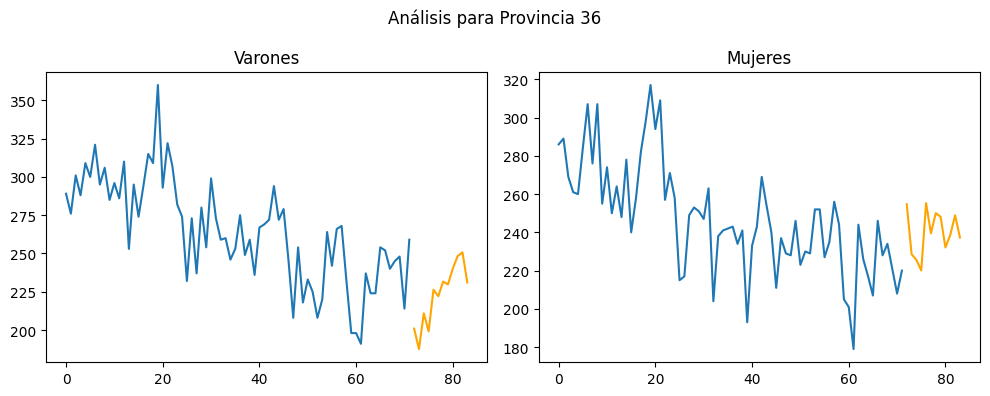

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.

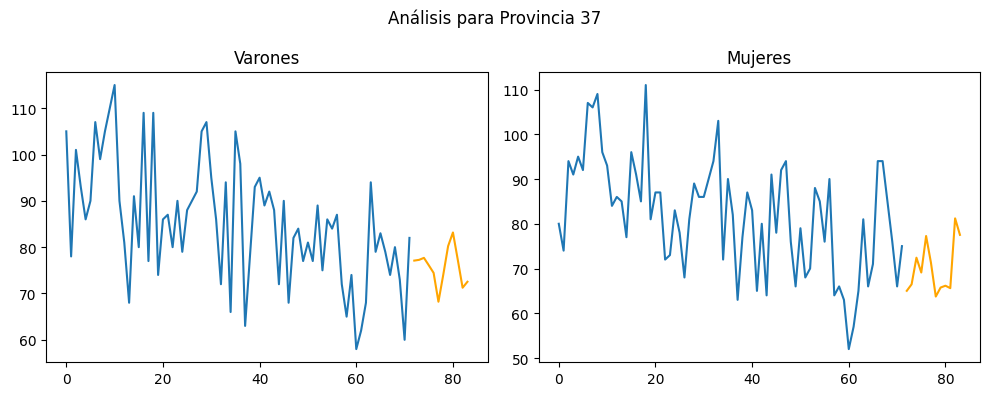

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.

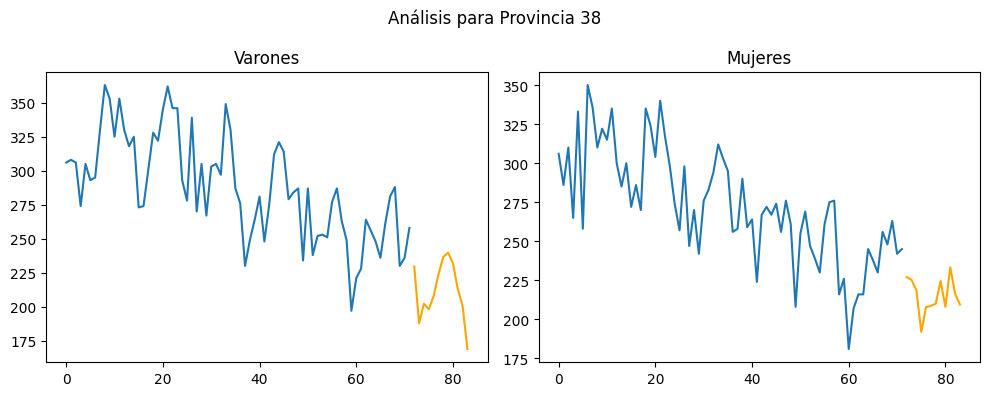

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.

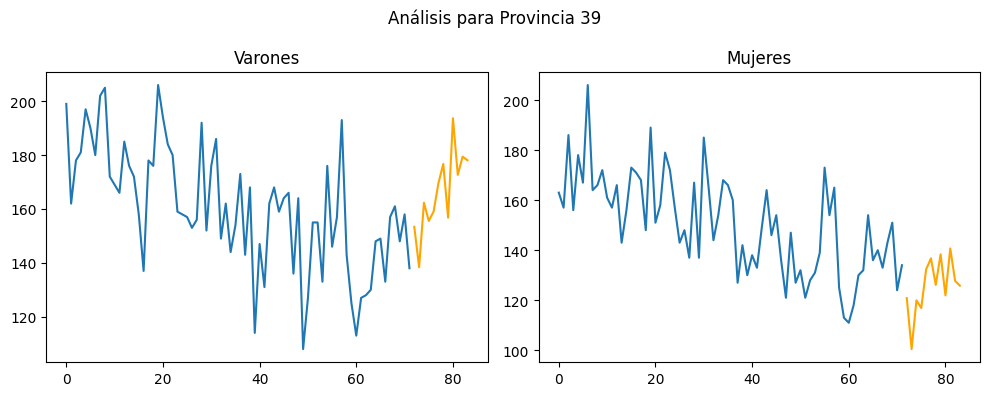

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.

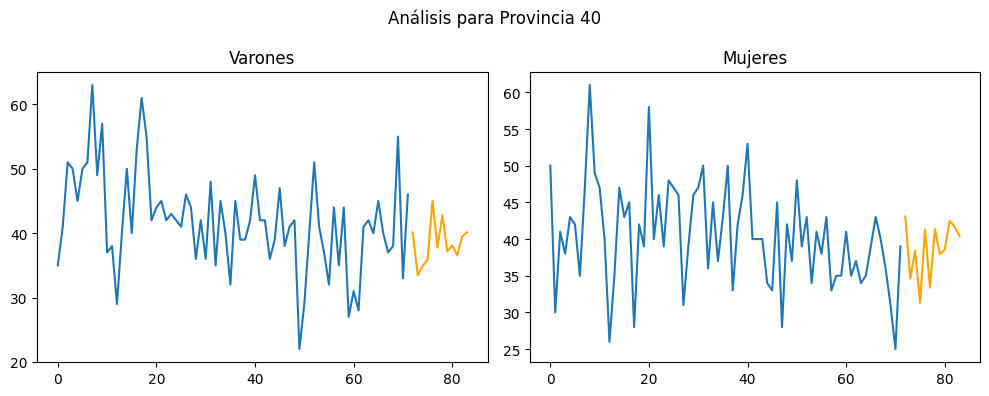

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.

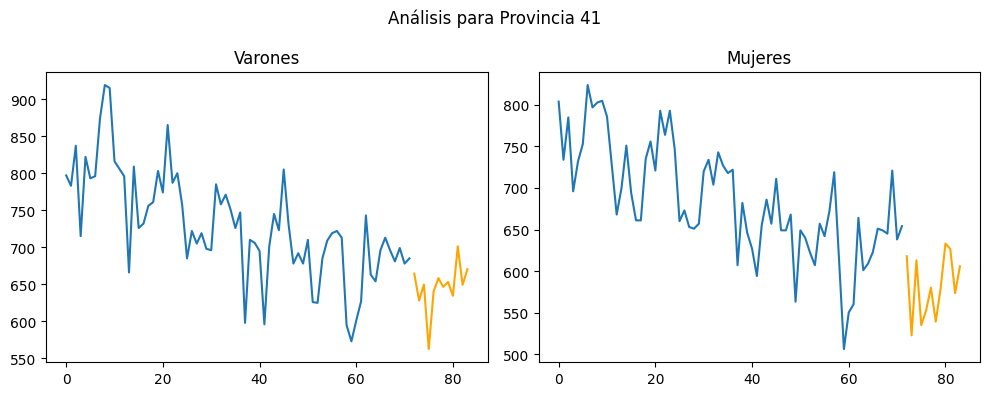

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
/usr/local/lib/python3.10/dist-packages/

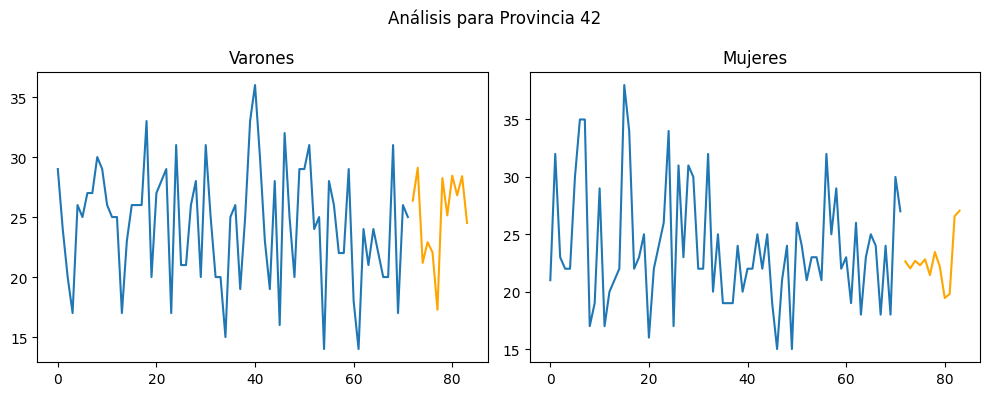

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.

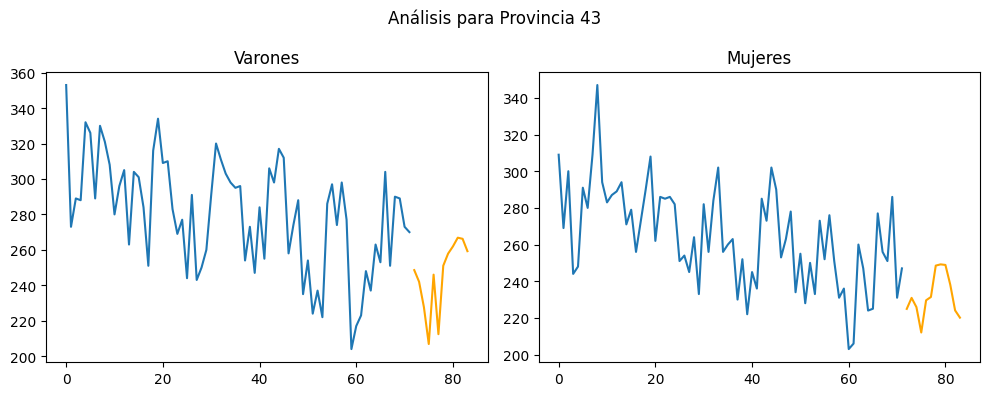

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.

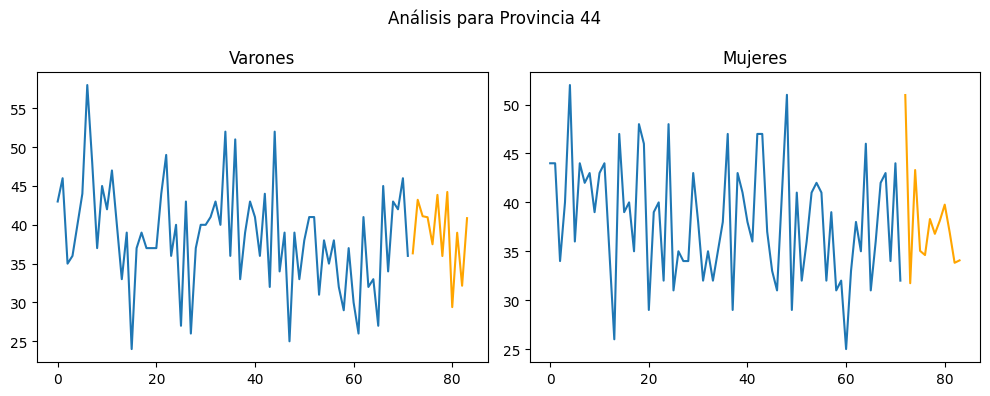

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.

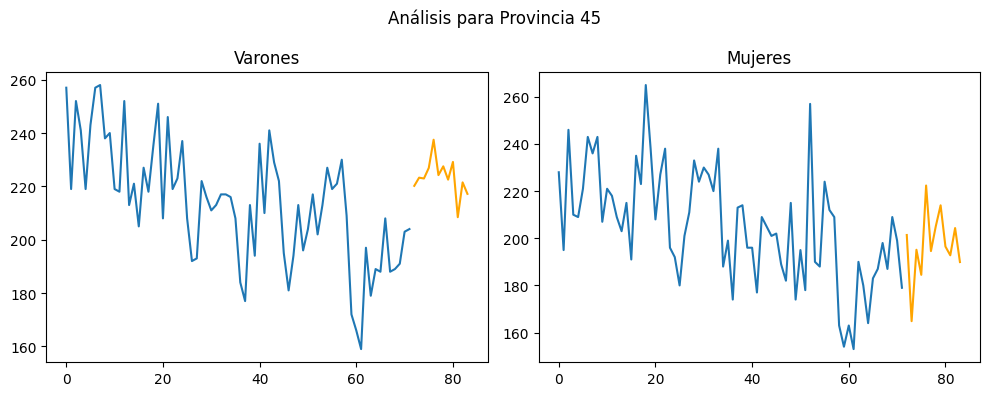

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.

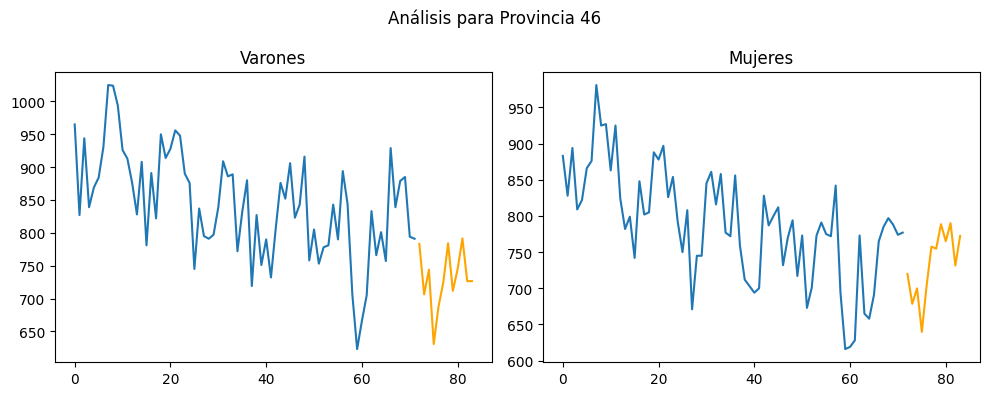

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.

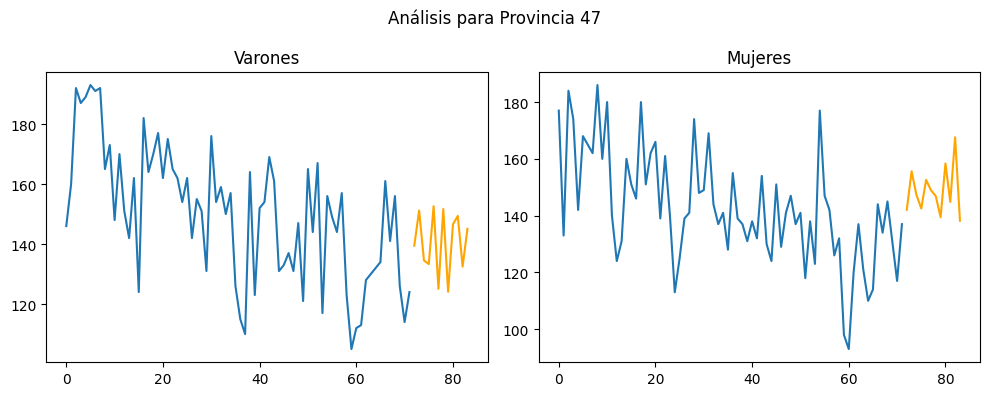

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.

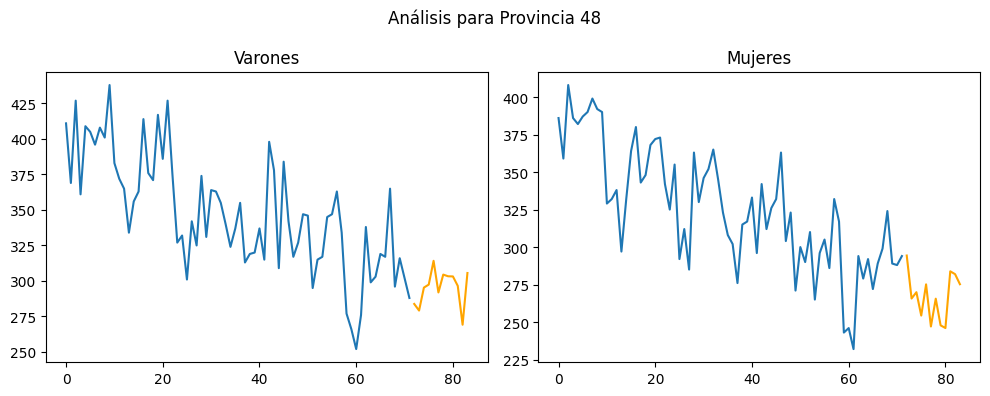

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.

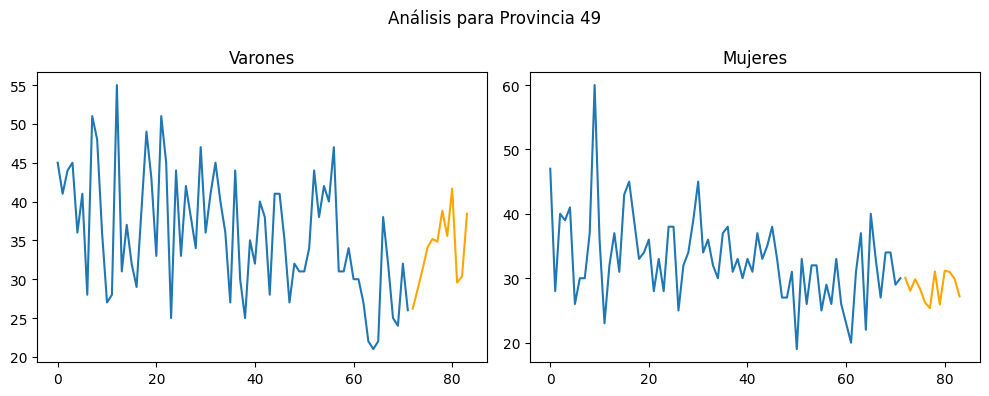

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/

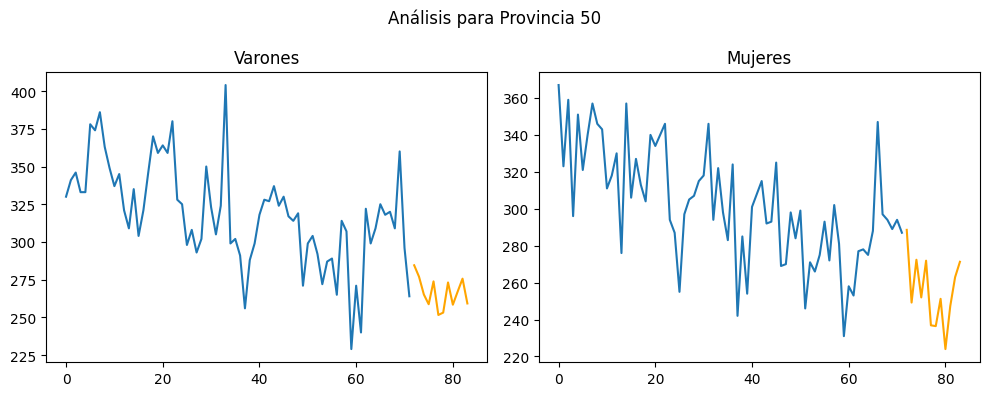

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmode

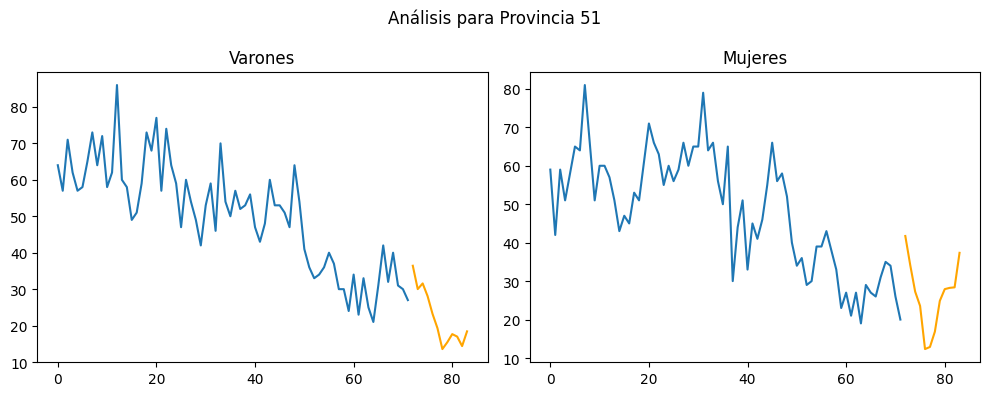

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.

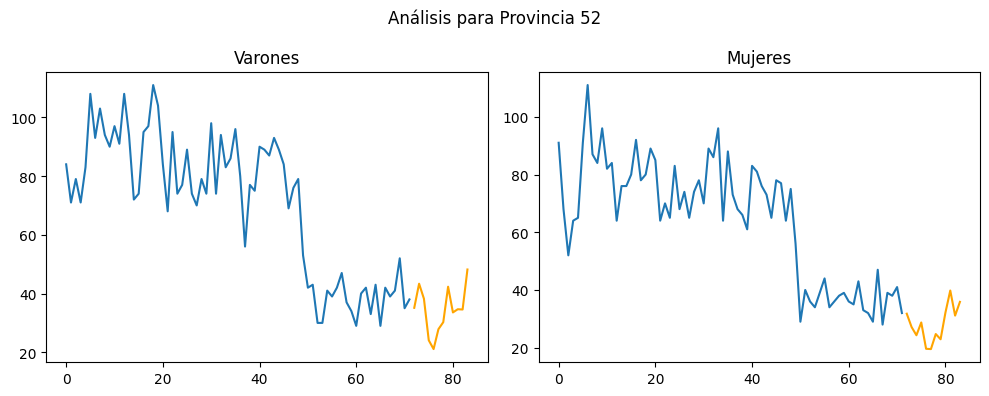

In [ ]:
#generalizado con un for para predecir todas las provincias.
for i in range(1,53):
    a = crear_provincia(i,varon)
    b = crear_provincia(i,mujer)
    a = transformar_dataframe3(a)
    b = transformar_dataframe3(b)
    
    X1 = a["count"]
    X_train_varon = X1[:59]
    X_test_varon = X1[60:72]



    X2 = b["count"]
    X_train_mujer = X2[:59]
    X_test_mujer = X2[60:72]

    T_missing = range(72, 84)

    model_varon = ARIMA(X_train_varon, order=(25,1,5))
    model_fit_varon = model_varon.fit()
    X_hat_series_varon = model_fit_varon.predict(start=T_missing[0],end=T_missing[-1],dynamic=True)

    model_mujer = ARIMA(X_train_mujer, order=(25,1,5))
    model_fit_mujer = model_mujer.fit()
    X_hat_series_mujer = model_fit_mujer.predict(start=T_missing[0],end=T_missing[-1],dynamic=True)
    plt.figure(figsize = (10,4))

    plt.subplot(1,2,1)
    plt.plot(X1)
    #plt.plot(X_train_varon, color='red')
    plt.plot(T_missing, X_hat_series_varon, color='orange')
    plt.title('Varones')
    plt.subplot(1,2,2)
    plt.plot(X2)
    #plt.plot(X_train_mujer, color='red')
    plt.plot(T_missing, X_hat_series_mujer, color='orange')
    plt.title('Mujeres')

    plt.suptitle('Análisis para Provincia {}'.format(i))
    plt.tight_layout()
    plt.show()

Observamos que en todas las provincias la tendencia es descendente y la predicción es mayormente descendente. En algunas se ha pegado un bajón muy alto en los últimos años y el algoritmo no predice que ese bajón continúe, sino que solo lo reduce frente a los años de antes del bajón. Pero por lo general estamos satisfechos con el resultado, que predice la tendencia descendente esperada.

Creamos un nuevo bucle for, pero esta vez en vez de hacer plot nos quedamos con los valores de las predicciones para poder hacer un plot del país entero con la suma de todas las predicciones de cada provincia y el sexo.
De esta forma visualizamos los 52 plots anteriores en uno solo y vemos si tiene sentido al compararlo con el total de los demás años.

In [ ]:
lista_de_datases_2021 = []
lista_de_datases_2022 = []
#datasets para guardar los datos de predicciones de cada año

#los datos faltantes de 2021 y 2022
T_missing = range(60, 72)
T_missing_2022 = range(72,84)
for i in range(1,53):
    a = crear_provincia(i,varon)
    b = crear_provincia(i,mujer)
    a = transformar_dataframe2(a)
    b = transformar_dataframe2(b)
  

    X = a["count"].to_numpy()
    X_train = a['count'][:59]
    X_test = X[60:72]


    model1 = ARIMA(X_train, order=(25,1,5))
    model_fit1 = model1.fit()

    #datos de predicciones de varon cada año
    X_hat_series_a2021 = model_fit1.predict(start=T_missing[0],end=T_missing[-1],dynamic=True)
    X_hat_series_a2022 = model_fit1.predict(start=T_missing_2022[0],end=T_missing_2022[-1],dynamic=True)

    X = b["count"].to_numpy()
    X_train = b['count'][:59]
    X_test = X[60:72]
    model1 = ARIMA(X_train, order=(25,1,5))
    model_fit1 = model1.fit()

    #datos de predicciones de mujer cada año
    X_hat_series_b2021 = model_fit1.predict(start=T_missing[0],end=T_missing[-1],dynamic=True)
    X_hat_series_b2022 = model_fit1.predict(start=T_missing_2022[0],end=T_missing_2022[-1],dynamic=True)


    lista_de_datases_2021.append(X_hat_series_a2021)
    lista_de_datases_2021.append(X_hat_series_b2021)
    lista_de_datases_2022.append(X_hat_series_a2022)
    lista_de_datases_2022.append(X_hat_series_b2022)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Che

In [ ]:
lista_de_datases_2022

[72    134.514816
 73    137.340137
 74    131.098688
 75    144.200396
 76    128.754604
 77    133.369687
 78    140.933134
 79    131.560585
 80    120.584110
 81    136.794095
 82    131.791897
 83    129.756265
 Name: predicted_mean, dtype: float64,
 72    134.240020
 73    132.421248
 74    142.430953
 75    130.858896
 76    137.799969
 77    136.330324
 78    130.796151
 79    137.529094
 80    117.240861
 81    118.395437
 82    131.369865
 83    130.980932
 Name: predicted_mean, dtype: float64,
 72    163.547284
 73    153.244908
 74    150.176152
 75    169.198552
 76    162.949664
 77    154.204630
 78    150.665356
 79    176.412684
 80    174.957198
 81    159.489282
 82    170.505574
 83    184.876007
 Name: predicted_mean, dtype: float64,
 72    130.314161
 73    135.077468
 74    129.378883
 75    121.164597
 76    124.226995
 77    139.643656
 78    124.946323
 79    149.547649
 80    130.048493
 81    128.017676
 82    132.042221
 83    121.961105
 Name: predicted_me

Aplanamos las listas de los valores para 2022 y 2021 y asi usar los de 2022 para su respectivo dataframe.

In [ ]:
lista_aplanada_2022 = []

for sublist in lista_de_datases_2022:
    lista_aplanada_2022.extend(sublist)

len(lista_aplanada_2022)

1248

In [ ]:
lista_aplanada_2021 = []

for sublist in lista_de_datases_2022:
    lista_aplanada_2021.extend(sublist)

len(lista_aplanada_2021)

1248

Recuperamos dataset plantilla usado previamente

In [ ]:
print(df_2022)

      PROI  SEXO  MESPAR  ANOPAR
6240     1     1       1    2022
6241     1     1       2    2022
6242     1     1       3    2022
6243     1     1       4    2022
6244     1     1       5    2022
...    ...   ...     ...     ...
7483    52     6       8    2022
7484    52     6       9    2022
7485    52     6      10    2022
7486    52     6      11    2022
7487    52     6      12    2022

[1248 rows x 4 columns]


Asi quedaria el dataset de 2022 acabado con las predicciones

In [ ]:
df_2022['count'] = lista_aplanada_2022
df_2022

PROI  SEXO  MESPAR  ANOPAR       count
6240     1     1       1    2022  134.514816
6241     1     1       2    2022  137.340137
6242     1     1       3    2022  131.098688
6243     1     1       4    2022  144.200396
6244     1     1       5    2022  128.754604
...    ...   ...     ...     ...         ...
7483    52     6       8    2022   58.297261
7484    52     6       9    2022   58.708606
7485    52     6      10    2022   53.750993
7486    52     6      11    2022   62.453958
7487    52     6      12    2022   53.435909

[1248 rows x 5 columns]

Nos quedamos con el total de nacimientos desde 2016 hasta 2021 por mes

In [ ]:
tot2016_2021 = suma_pais["count"]
tot2016_2021

0     34490
1     32093
2     34292
3     31719
4     33439
      ...  
67    29640
68    30229
69    30135
70    28452
71    28574
Name: count, Length: 72, dtype: int64

Transformamos a pais el dataset de 2022 para asi tener los nacimientos totales en cada mes, sin importar el sexo.

In [ ]:
tot2022 = transformar_a_pais(df_2022)
tot2022

fecha         count
0   2022-01-01  34744.051836
1   2022-02-01  33614.441597
2   2022-03-01  34757.873166
3   2022-04-01  33792.838427
4   2022-05-01  34950.377250
5   2022-06-01  34434.411575
6   2022-07-01  35726.975637
7   2022-08-01  35786.224662
8   2022-09-01  35743.258647
9   2022-10-01  36019.902394
10  2022-11-01  35315.711715
11  2022-12-01  35337.354904

Visualizamos la prediccion de los datos(en rojo) comparada con los valores de entrada, desde el 2016 hasta el 2021 (en azul).

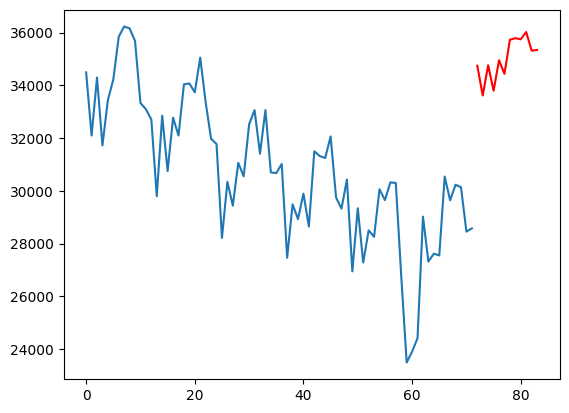

In [ ]:
nuevos_indices = range(72, 84)
tot2022.index = nuevos_indices


X_train = tot2016_2021
X_test = tot2022['count']

plt.plot(X_train)
plt.plot(X_test, color='red')
plt.show()

Vemos que a pesar de que al hacer la predicción por cada provincia y por cada sexo veíamos resultados convincentes, al unir todas las predicciones el resultado como suma total es malo. Achacamos esto a que vaya acumulando muchos errores por hacerlo de forma individualizada ya que tenemos diferentes fallos por cada predicción de cada sexo y cada provincia. Cuando lo hicimos de la forma más general posible los resultados eran mejores. Pero con esto damos la oportunidad al usuario de predecir una provincia y un sexo a elegir, para hacer un análisis con la mayor profundidad posible.